<a href="https://colab.research.google.com/github/madziejm/1e100-ibu/blob/master/1e100ibu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $1 e^{100} \text{ IBU}$

## PALE LAGER

### Preliminary

In [ ]:
!jupyter nbextension enable --py widgetsnbextension

##### Dependencies

In [ ]:
import torch
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'dev = {dev}')

dev = cpu


In [ ]:
try: # mount user's Google Drive if on Colab to save training artifacts
    from google.colab import drive
    drive.mount('/drive')
    ROOT_DIR = '/content/'
    MODEL_ROOT_DIR = '/drive/MyDrive/Colab Notebooks/1e100ibu/saves/'
except ImportError:
    ROOT_DIR = './'
    MODEL_ROOT_DIR = './saves/'

Mounted at /drive


In [ ]:
!pip install --quiet icecream
!pip install --quiet -Iv torch==1.10.1
!pip install --quiet -Iv torchtext==0.11.1
!pip install --quiet gdown
!pip install --quiet wordcloud

In [ ]:
from icecream import ic
import os

In [ ]:
!pip install 'spacy<3.3.0,>=3.2.0' --quiet
!python -m spacy download en_core_web_sm --quiet
!python -m spacy download pl_core_news_md --quiet
!pip install seaborn

In [ ]:
!pip show spacy | egrep Version
# we want SpaCy 3, crucial!
!pip show torch | egrep Version
!pip show torchtext | egrep Version

Version: 3.2.1
Version: 1.10.1
Version: 0.11.1


### Dataset representation
Here we introduce `BaseReviews`, `RateBeerReviews`, `OcenPiwoReviews` classes. For each dataset we pick 20k most common words vocabulary and then then map them to numerical ID-s. 0th index is used for unknown token.

We recommend at least 16 GB RAM/RAM+swap for digesting whole SNAP Ratebeer dataset. We provide serialized version that is ready to use for both of datasets and has lower memory footprint.

In [ ]:
from collections import Counter
from torchtext._torchtext import (Vocab as VocabPybind) # make use of some hidden interface
from torchtext.vocab import Vocab, build_vocab_from_iterator
from tqdm.notebook import trange, tqdm
import gc # garbage collector interface
import io
import re
import spacy # nlp toolkit
import torch
import pickle


class BaseReviews(torch.utils.data.Dataset):
    def __init__(self, aspects, aspect_max, aspect_ratings, texts, unkn_tok, _len, anchor_words, overall_index):
        self.aspects = aspects
        self.aspect_count = len(aspects)
        self.aspect_max = aspect_max
        self._aspect_ratings = aspect_ratings
        self._texts = texts
        self.unkn_tok = unkn_tok
        self._len = _len
        self.anchor_words = anchor_words
        self.vocab = None
        self.overall_index = overall_index

    def dump(self, dest_path, filename):
        contents = {
            'aspects'        : self.aspects,
            'aspect_max'     : self.aspect_max,
            '_aspect_ratings': self._aspect_ratings,
            '_texts'         : self._texts,
            'unkn_tok'       : self.unkn_tok,
            '_len'           : self._len,
            'anchor_words'   : self.anchor_words,
            'vocab'          : self.vocab,
            'overall_index'  : self.overall_index,
        }
        with open(f'{dest_path}/{filename}', 'wb') as f:
            pickle.dump(contents, f)
    
    def load(self, dest_path, filename):
        with open(f'{dest_path}/{filename}', 'rb') as f:
            contents = pickle.load(f)
            self.aspects         = contents['aspects']
            self.aspect_max      = contents['aspect_max']
            self._aspect_ratings = contents['_aspect_ratings']
            self._texts          = contents['_texts']
            self.unkn_tok        = contents['unkn_tok']
            self._len            = contents['_len']
            self.anchor_words    = contents['anchor_words']
            self.vocab           = contents['vocab']
            self.overall_index   = contents['overall_index']

    def __getitem__(self, i):
        # # 1 # python
        # sentences = tuple(sent for sent in self._texts[i])
        # ratings = tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count))
        # 2 # tensor
        sentences = tuple(torch.LongTensor(sent) for sent in self._texts[i])
        # changed LongTensor to IntTensor
        ratings = torch.IntTensor(tuple(int(self._aspect_ratings[a][i]) for a in range(self.aspect_count)))
        # # 3 # dev
        # sentences = tuple(torch.tensor(sent) for sent in self._texts[i])
        # ratings = torch.tensor(tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count)))
        return (sentences, ratings)

    def __len__(self):
        return self._len

In [ ]:
class RateBeerReviews(BaseReviews):
    """
    beer/name: John Harvards Simcoe IPA
    beer/beerId: 63836
    beer/brewerId: 8481
    beer/ABV: 5.4
    beer/style: India Pale Ale &#40;IPA&#41;
    review/appearance: 4/5
    review/aroma: 6/10
    review/palate: 3/5
    review/taste: 6/10
    review/overall: 13/20
    review/time: 1157587200
    review/profileName: hopdog
    review/text: On tap at the Springfield, PA location. Poured a deep and cloudy orange (almost a copper) color with a small sized off white head. Aromas or oranges and all around citric. Tastes of oranges, light caramel and a very light grapefruit finish. I too would not believe the 80+ IBUs - I found this one to have a very light bitterness with a medium sweetness to it. Light lacing left on the glass.
    """
    def __init__(self):
        aspects = ['appearance', 'aroma', 'palate', 'taste', 'overall']
        super().__init__(
            aspects        = aspects,
            aspect_max     = [5, 10, 5, 10, 20],
            aspect_ratings = [ [] for _ in aspects ],
            texts          = [],
            unkn_tok       = '<unk>', # unknown/out of vocabulary token
            _len            = 0,
            anchor_words = {
                'appearance' : ('appearance', 'color'),
                'aroma'      : ('aroma'),
                'palate'     : ('palate', 'mouthfeel'),
                'taste'      : ('taste'),
                'overall'    : ('overall'),
            },
            overall_index   = 4
        )
        self.pipe = None

    def build(self, filepath=f'{ROOT_DIR}/SNAP-Ratebeer.txt', max_reviews=float('inf'), min_word_freq=None, max_word_count=None):
        with io.open(filepath, encoding='utf-8') as f:
            for line in tqdm(f, total=(40938282 if max_reviews == float('inf') else max_reviews * 14), desc='Reading data'):
                if line == '\n': # separator
                    self._len += 1
                    if max_reviews <= self._len:
                        break
                elif line.startswith('review/appearance: '):
                    line = line[len('review/appearance: '):]
                    self._aspect_ratings[0].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/aroma: '):
                    line = line[len('review/aroma: '):]
                    self._aspect_ratings[1].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/palate: '):
                    line = line[len('review/palate: '):]
                    self._aspect_ratings[2].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/taste: '):
                    line = line[len('review/taste: '):]
                    self._aspect_ratings[3].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/overall: '):
                    line = line[len('review/overall: '):]
                    self._aspect_ratings[4].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/text: '):
                    line = line[len('review/text: '):]
                    if line.startswith('UPDATED:'):
                        line = line[len("UPDATED: APR 29, 2008"):] # drop prefix
                    line = re.sub('~', ' ', line.strip()) # remove whitespace incl. trailing newline and tildes that can be found in data for some reason
                    if line:
                        self._texts.append(line)
                    else: # some reviews do not have associated text; unwind (remove) their ratings for each aspect
                        for aspect_ratings in self._aspect_ratings:
                            aspect_ratings.pop()
                        self._len -= 1
        self._post_process(min_word_freq, max_word_count) # 20K words should be okay
    
    def _fetch_nlp_pipeline(self):
        if not self.pipe:
            nlp = spacy.util.get_lang_class('en')()
            nlp.add_pipe("sentencizer", config={"punct_chars": ['.', '?', '!']})
            nlp.Defaults.stop_words |= { '-', '+'}
            nlp.Defaults.stop_words -= {'mostly', 'whole', 'indeed', 'quite', 'ever', 'nothing', 'perhaps', 'not', 'no', 'only', 'well', 'really', 'except'}
            self.pipe = lambda reviews: nlp.pipe(reviews)
    
    def _free_nlp_pipeline(self):
        self.nlp = None

    def tokenize_reviews(self, reviews_texts: str):
        return [tuple(list(tok.lower_ for tok in sent if not tok.is_stop and not tok.is_punct and not tok.is_space and len(tok) > 2) for sent in doc.sents if 0 != len(sent)) for doc in self.pipe(reviews_texts)]
    
    def id_map_reviews(self, texts):
        return [tuple(self.vocab.lookup_indices(sent) for sent in text) for text in texts]
    
    def _post_process(self, min_word_freq=None, max_word_count=None):
        assert (min_word_freq is not None) ^ bool(max_word_count is not None), "provide one of min_word_freq and max_word_count"
        self._fetch_nlp_pipeline()
        print("Spacy pipe (tokenization&sentence split)..")
        gc.collect() # force garbage collection
        self._texts = self.tokenize_reviews(self._texts)
        for i, text in enumerate(self._texts):
            assert 0 != len(text) # make sure no empty reviews again (new could be introduced by removing stop words unfortunately)
        print("Building vocab (word-id mapping)..")
        gc.collect() # force garbage collection
        sent_gen = (sent for text in self._texts for sent in text)
        if min_word_freq:
            self.vocab = build_vocab_from_iterator(sent_gen, specials=[self.unkn_tok], min_word_freq=5)
        else:
            words = Counter()
            for tokens in sent_gen:
                words.update(tokens)
            words = [word for word, freq in words.most_common(max_word_count)] # list sorted by frequency yikees
            self.vocab = Vocab(VocabPybind(words, None))
        self.vocab.insert_token(self.unkn_tok, 0)
        self.vocab.set_default_index(self.vocab[self.unkn_tok]) # set index for out-of-vocabulary words
        print("Mapping words to ids..")
        gc.collect() # force garbage collection
        self._texts = self.id_map_reviews(self._texts)
        gc.collect() # force garbage collection

If you want to read dataset from dataset file, set `USE_RATEBEER_PICKLE` to true in the cell below. If you left them untouched, it'll be read from serialized `RateBeerReviews` class object instead of parsing text file.

In [ ]:
%env USE_RATEBEER_PICKLE=true

env: USE_RATEBEER_PICKLE=true


In [ ]:
%%bash

if [ "$USE_RATEBEER_PICKLE" = true ]
then # download pickle
    if [ ! -f './ratebeer-20K-vocab.pickle' ]
    then
        gdown --id '1VBDjyR4jpzAgzcDUGNQFguOfLC3rtOV_' # https://drive.google.com/file/d/1VBDjyR4jpzAgzcDUGNQFguOfLC3rtOV_/view?usp=sharing  # 20K words dataset
        # gdown --id '1ebDMDlOxtFh8B5i8lajR7q3kq-0hM02j' # https://drive.google.com/file/d/1ebDMDlOxtFh8B5i8lajR7q3kq-0hM02j/view?usp=sharing # min frequency 5 words dataset
    fi
else # download original dataset
    if [ ! -f './SNAP-Ratebeer.txt' ]
    then
        gdown --id '12tEEYQcHZtg5aWyfIiWWVIDAJNT-5d_T' # https://drive.google.com/file/d/12tEEYQcHZtg5aWyfIiWWVIDAJNT-5d_T/view?usp=sharing
        echo "Dataset head (trailing newline makes entry end): "
        export $RATEBEER_FILE='./SNAP-Ratebeer.txt'
        head -n 16 $RATEBEER_FILE
        iconv -f ISO-8859-1 -t UTF-8 $RATEBEER_FILE -o {RATEBEER_FILE}.new && mv {RATEBEER_FILE}.new $RATEBEER_FILE
    fi
fi

In [ ]:
rb = RateBeerReviews()

if os.environ.get('USE_RATEBEER_PICKLE') == 'true':
    rb.load('./', 'ratebeer-20K-vocab.pickle')
else: # build pickle
    rb.build('./SNAP-Ratebeer.txt', max_word_count=20000)
    print('Dumping..')
    rb.dump('./', 'ratebeer-20K-vocab.pickle')

In [ ]:
from collections import Counter
from torchtext._torchtext import (Vocab as VocabPybind) # make use of some hidden interface
from torchtext.vocab import Vocab, build_vocab_from_iterator
from tqdm.notebook import trange, tqdm
import gc # garbage collector interface
import io
import re
import spacy # nlp toolkit
import torch
import json

class OcenPiwoReviews(BaseReviews):
    def __init__(self):
        aspects = ['ogólny', 'smak', 'zapach', 'wygląd',]
        super().__init__(
            aspects        = aspects,
            aspect_max     = [10, 10, 10, 10],
            aspect_ratings = [ [] for _ in aspects ],
            texts          = [],
            unkn_tok       = '<unk>', # unknown/out of vocabulary token
            _len            = 0,
            anchor_words = {
                'ogólny'     : ('ogólnie'),
                'smak'       : ('smak'),
                'zapach'     : ('zapach'),
                'wygląd'     : ('wygląd', 'wygląda')
            },
            overall_index   = 0
        )
        self.pipe = None

    def build(self, filepath=f'{ROOT_DIR}/ocen-piwo-utf8.json', min_word_freq=None, max_word_count=None):
        with io.open(filepath, encoding='utf-8') as f:
            json_dict = json.loads(f.read())

            for i, reviews in enumerate(json_dict.values()):
                for sentences, ratings in reviews:
                    self._len += 1

                    for aspect in range(self.aspect_count):
                        self._aspect_ratings[aspect].append(int(ratings[aspect]))

                    self._texts.append(sentences)
        self._post_process(min_word_freq, max_word_count)

    def _fetch_nlp_pipeline(self):
        if not self.pipe:
            nlp = spacy.load('pl_core_news_md')
            nlp.add_pipe("sentencizer", config={"punct_chars": ['.', '?', '!']})
            nlp.Defaults.stop_words |= { '-', '+'}
            self.pipe = lambda reviews: nlp.pipe(reviews)
    
    def _free_nlp_pipeline(self):
        self.nlp = None

    def tokenize_reviews(self, reviews_texts: str):
        return [tuple(list(tok.lemma_ for tok in sent if not tok.is_stop and not tok.is_punct and not tok.is_space and len(tok) > 2) \
            for sent in doc.sents if 0 != len(sent)) for doc in self.pipe(reviews_texts)]
    
    def id_map_reviews(self, texts):
        return [tuple(self.vocab.lookup_indices(sent) for sent in text) for text in texts]
    
    def _post_process(self, min_word_freq=None, max_word_count=None):
        assert (min_word_freq is not None) ^ bool(max_word_count is not None), "provide one of min_word_freq and max_word_count"
        self._fetch_nlp_pipeline()
        print("Spacy pipe (tokenization&sentence split)..")
        gc.collect() # force garbage collection
        self._texts = self.tokenize_reviews(self._texts)
        for i, text in enumerate(self._texts):
            assert 0 != len(text) # make sure no empty reviews again (new could be introduced by removing stop words unfortunately)
        print("Building vocab (word-id mapping)..")
        gc.collect() # force garbage collection
        sent_gen = (sent for text in self._texts for sent in text)
        if min_word_freq:
            self.vocab = build_vocab_from_iterator(sent_gen, specials=[self.unkn_tok], min_word_freq=5)
        else:
            words = Counter()
            for tokens in sent_gen:
                words.update(tokens)
            words = [word for word, freq in words.most_common(max_word_count)] # list sorted by frequency yikees
            self.vocab = Vocab(VocabPybind(words, None))
        self.vocab.insert_token(self.unkn_tok, 0)
        self.vocab.set_default_index(self.vocab[self.unkn_tok]) # set index for out-of-vocabulary words
        print("Mapping words to ids..")
        gc.collect() # force garbage collection
        self._texts = [tuple(self.vocab.lookup_indices(sent) for sent in text) for text in self._texts]
        gc.collect() # force garbage collection

If you want to read dataset from dataset file, set `USE_OCENPIWO_PICKLE` to true in the cell bellow. If you left them untouched, it'll be read from serialized `OcenPiwoReviews` class object instead of parsing text file.


In [ ]:
%env USE_OCENPIWO_PICKLE=true

env: USE_OCENPIWO_PICKLE=true


In [ ]:
%%bash

if [ "$USE_OCENPIWO_PICKLE" = true ]
then # download pickle
    if [ ! -f './ocenpiwo-20K-vocab.pickle' ]
    then
        gdown --id '1zUXnY0UqvevNnePThTfquF6hUxxPOls9' # https://drive.google.com/file/d/1zUXnY0UqvevNnePThTfquF6hUxxPOls9/view  # 20K words dataset
    fi
else # download original dataset
    if [ ! -f './ocen-piwo-utf8.json' ]
    then
        gdown --id '1RM_Sk8QeOQnjnje0gwxQfJIOIK0KLLWV' # https://drive.google.com/file/d/1RM_Sk8QeOQnjnje0gwxQfJIOIK0KLLWV
    fi
fi

In [ ]:
op = OcenPiwoReviews()

if os.environ.get('USE_OCENPIWO_PICKLE') == 'true':
    op.load('./', 'ocenpiwo-20K-vocab.pickle')
else: # build pickle
    op.build('./ocen-piwo-utf8.json', max_word_count=20000)
    print('Dumping..')
    op.dump('./', 'ocenpiwo-20K-vocab.pickle')

### Aspect assignement training

#### Algorithm

This part is strictly based on the PALELAGER paper.

Two types of weights are introduced: 
- $\Theta_{kw}$ indexed by $w$ - words and $k$ - aspects.
- $\phi_{kv_{k}w}$ indexed by $w$ - words, $k$ - aspects and $v_{k}$ - aspect rating.

Assume that all ratings are known for a set of reviews and a single review's sentence $s$ is being considered. Then one can come up with a likelihood score $L$ that the sentence describes some particular aspect, namely $k$.

$$
    L^{(\Theta, \phi)}(\text{aspect}(s) = k \ | \ \text{sentence} \ s,     \text{rating} \ v) =
    \begin{equation}
        \sum_{w \in s}^{} \Bigg\{ \Theta_{kw} + \phi_{kv_{k}w} \Bigg\}
    \end{equation}
$$

We can softmax the likelihoods for all target aspects

$$
    P^{(\Theta, \phi)}(\text{aspect}(s) = k \ | \ \text{sentence} \ s,     \text{rating} \ v) = \frac{1}{Z_s^{(\Theta, \phi)}} \exp{}
    \begin{equation}
        \sum_{w \in s}^{} \Bigg\{ \Theta_{kw} + \phi_{kv_{k}w} \Bigg\}
    \end{equation}
$$
where $Z$ is softmax normalization factor is:
$$
    Z_s^{(\Theta, \phi)} = 
    \begin{equation}
        \sum_{k = 1}^{K} \exp \sum_{w \in s}^{} \Bigg\{ \Theta_{kw} + \phi_{kv_{k}w} \Bigg\}
    \end{equation}
$$

Example:

"I like the smell of pineapple and ham in the morning. Very cool looking box. I love this ***pizza***." 
~ Descartes

Aspects ratings:
Aroma: 5/5
Box: 5/5
Overall: 5/5

It is trivially intuitive, that the 1st sentence discusses the aroma aspect, the 2nd one discussed box rating and the last sentence discusses overall rating. For each word, we assign a score that is a sum of appropriate weights.


| aspect/word |  I   |                                              love                                              | this | pizza |
|:-----------:|:----:|:----------------------------------------------------------------------------------------------:|:----:|:-----:|
|     Box     | 0.3  |                                               0                                                | 0.3  |  0.2  |
|    Aroma    | 0.1  | $$\theta_{k=\text{aroma}, \ w=\text{love}} + \Phi_{k=\text{aroma}, \ v_k=5/5, \ w=\text{love}}$$ | 0.2  |   2   |
|   Overall   | -0.2 |                                               10                                               | -0.3 |   3   |

In the middle cell, we wrote down the formula for calculating the score.  
Based on the scores a probability of sentence discussing aspect is calculated.


We initialize Thetas that explicitly mention aspect names to ones:
```
anchor_words = {
                'appearance' : ('appearance', 'color'),
                'aroma'      : ('aroma'),
                'palate'     : ('palate', 'mouthfeel'),
                'taste'      : ('taste'),
                'overall'    : ('overall'),
            },
```
That's why at first training will proceed with promoting all words that occur in sentences with the words mentioned before. Later training can proceed by simply propagating this information by further lowering the negative log-likelihood.

We minimise the objective proceeding with stochastic gradient descent implemented in the PyTorch framework.

#### Implementation

In [ ]:
from torch.utils.data import random_split, DataLoader
import datetime
from scipy.optimize import linear_sum_assignment

# for wordcloudsdest_path=dest_path
import unicodedata
import numpy as np
import os
import re
from PIL import Image
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import functools
from operator import iadd
from typing import List
import unicodedata
from math import ceil

class AspectModel():
    def __init__(self, dataset):
        self.ds = dataset
        self.init_weights()

    def init_weights(self):
        word_count = len(self.ds.vocab.get_itos())
        self.theta = torch.rand((word_count, self.ds.aspect_count), device=dev)
        # scale to [-0.1, 0.0], as we enforce this weight to 1.0 for some words later on
        self.theta = self.theta * -0.1
        # enforce 1 initialization on aspect name (page 4)
        for aspect_idx, aspect in enumerate(self.ds.aspects):
            words = self.ds.anchor_words[aspect]

            if isinstance(words, str):
                words = [words]
            else:
                words = list(words)

            words_ids = self.ds.vocab.lookup_indices(words)
            for word_id in words_ids:
                self.theta[word_id, aspect_idx] = 1.0
        self.theta.requires_grad_()

        # introduce separate phi for each aspect
        # self.phis = [torch.rand((word_count, self.ds.aspect_max[i])).to(dev) for i in range(self.ds.aspect_count)]
        self.phis = [torch.zeros((word_count, self.ds.aspect_max[i]), device=dev, dtype=self.theta.dtype) for i in range(self.ds.aspect_count)]
        # normalize that sum across all words is 1 for a given aspect (eq. 7) # do not normalize as for now # and forever and ever
        # self.phis = [phi / phi.sum(dim=0) for phi in self.phis]
        for phi in self.phis: phi.requires_grad_()
    
    def word_clouds(self, dest_path=MODEL_ROOT_DIR, filename='words.png', show=True):
        # words = list(str(unicodedata.normalize('NFD', x).encode('ascii', 'ignore'))[2:-1] for x in self.ds.vocab.get_itos())
        # we skip <unk> token (index 0)
        words = self.ds.vocab.get_itos()[1:]
        fig = plt.figure(figsize=(max(self.ds.aspect_max) + 1, len(self.ds.aspects)))
        plt.subplots_adjust(wspace=0.2)
        i = 0

        for aspect in range(self.ds.aspect_count):
            aspect_name = self.ds.aspects[aspect]
            # we skip <unk>
            atheta = self.theta[:, aspect].tolist()[1:]
            
            zipped = list(zip(words, atheta))

            wc = WordCloud(background_color="white", color_func=lambda *args, **kwargs: 'black', width=1000, height=1000)
            wc.generate_from_frequencies(dict(zipped))

            fig.add_subplot(self.ds.aspect_count, max(self.ds.aspect_max) + 1, i * (max(self.ds.aspect_max) + 1) + 1)
            plt.imshow(wc)
            plt.title(f'{aspect_name} Theta', fontsize=2)
            plt.axis("off")

            for rating in range(self.ds.aspect_max[aspect]):
                # we skip <unk>
                aphi = self.phis[aspect][:, rating].tolist()[1:]

                zipped = list(zip(words, aphi))
                sorted_zip = sorted(zipped, reverse=True, key=lambda x: x[1])[:200]

                if any(a == 0 for _, a in sorted_zip):
                    print(f'Omitting {aspect_name} Phi {str(rating + 1)}')
                    continue

                wc = WordCloud(background_color="white", color_func=lambda *args, **kwargs: 'black', width=1000, height=1000)
                wc.generate_from_frequencies(dict(zipped))
                fig.add_subplot(self.ds.aspect_count, max(self.ds.aspect_max) + 1, i * (max(self.ds.aspect_max) + 1) + rating + 2)

                plt.imshow(wc)
                plt.title(f'{aspect_name} Phi {str(rating + 1)}', fontsize=2)
                plt.axis("off")

            i += 1
        plt.savefig(f'{dest_path}/{filename}', dpi=600)
        plt.show(block=show)
    
    def rev_words_thetas(self, rev_sens_ids):
        """
        Fetch Thetas for a review
        """
        return [self.theta[sen_ids] for sen_ids in rev_sens_ids]

    def rev_words_phis(self, rev_sens_ids):
        """
        Fetch Phis for a review
        """
        return [[self.phis[aspect_idx][sen_ids, :] for aspect_idx in range(self.ds.aspect_count)] for sen_ids in rev_sens_ids]
    
    def dump_weights(self, dest_path=MODEL_ROOT_DIR, filename=''):
        weights = {'phis': self.phis, 'theta': self.theta}
        torch.save(weights,  f'{dest_path}/{filename}')

    def load_weights(self, src_path):
        weights = torch.load(src_path, map_location=torch.device(dev))
        self.theta = weights['theta']
        self.phis  = weights['phis']
    
    def _linear_assignement(self, costs):
        # for nll we want to minimize
        return linear_sum_assignment(costs, maximize=False)
    
    def plot_nll_history(self, dir, filename):
        plt.figure().set_facecolor('white') # no alpha please
        plt.xlabel('epoch')
        plt.ylabel('NLL')
        plt.xlim(left=0.0, right=self.train_epoch_history[-1])
        plt.ylim(bottom=min(0.0, min(self.train_nll_history)), top=max(max(self.train_nll_history), max(self.valid_nll_history)))
        plt.plot(self.train_epoch_history, self.train_nll_history, '-o')
        plt.plot(self.valid_epoch_history, self.valid_nll_history, '-o')
        plt.legend(['train batch NLL', 'valid mean batch NLL'], loc='upper right')
        plt.title('Train and valid dataset NLL')
        plt.savefig(os.path.join(dir, filename))
        plt.show()

    @staticmethod
    def experiments(dataset, root_dir=MODEL_ROOT_DIR, max_batches=None, save_freq=5000, train_split=0.8):
        assert max_batches # we stop training at max_batches batches done, because epochs differ much between datasets

        for _ in range(1):
            directory = str(datetime.datetime.now()) + f'-{type(dataset)}'
            path = os.path.join(root_dir, directory)
            os.mkdir(path)
            
            model = AspectModel(dataset)
            model.train(dest_path=path, max_batches=max_batches, save_freq=save_freq, train_split=train_split)
            
        for _ in range(1):
            directory = str(datetime.datetime.now()) + '-cyclic' + f'-{type(dataset)}'
            path = os.path.join(root_dir, directory)
            os.mkdir(path)

            model = AspectModel(dataset)
            model.train(dest_path=path, sched='cyclic', max_batches=max_batches, save_freq=save_freq, train_split=train_split)
            
        for _ in range(1):
            directory = str(datetime.datetime.now()) + '-adam' + f'-{type(dataset)}'
            path = os.path.join(root_dir, directory)
            os.mkdir(path)

            model = AspectModel(dataset)
            model.train(dest_path=path, optim='adam', max_batches=max_batches, save_freq=save_freq, train_split=train_split)

    def valid_nll(self, debug=False):
        nlls = []
        with torch.no_grad():
            valid_loader = DataLoader(self.valid_ds, batch_size=100, collate_fn=lambda x: x) # do not use default collate function as it requires fixed-length input and raises this exception otherwise https://github.com/pytorch/pytorch/issues/42654
            for i, batch in enumerate(tqdm(valid_loader, leave=None, desc='validation')):
                batch_nlls = []
                for (rev_sents_ids, review_aspects_scores) in batch:
                    rev_thetas = self.rev_words_thetas(rev_sents_ids)
                    rev_phis   = self.rev_words_phis(rev_sents_ids)
                    aspect_sents_scores = torch.stack(
                        [
                        rev_thetas[j].sum(dim=0) + torch.stack(tuple(rev_phis[j][a][:, review_aspects_scores[a] - 1].sum() for a in range(self.ds.aspect_count))) # 1 x aspect count
                        for j in range(len(rev_sents_ids))
                        ],
                    ) # sent count x aspect count
                    softmax = -torch.nn.functional.log_softmax(aspect_sents_scores, dim=1)

                    sents_aspect_preds_max = torch.argmin(softmax, dim=1)
                    row_ind, col_ind = self._linear_assignement(costs=softmax.detach().cpu().numpy())
                    sents_aspect_preds_linear = sents_aspect_preds_max

                    sents_aspect_preds_linear[row_ind] = torch.from_numpy(col_ind).to(dev)
                    
                    batch_nlls.append(softmax.take_along_dim(sents_aspect_preds_linear[:, None], dim=1).sum().cpu().item())
                nlls.append(functools.reduce(lambda a, b: a + b, batch_nlls))
        nll_sum = functools.reduce(lambda a, b: a + b, nlls)
        if debug: ic(nll_sum)
        if debug: ic(torch.exp(-torch.tensor(nll_sum)))
        mean_batch_nll = nll_sum / len(nlls)
        return mean_batch_nll

    # doesnt really work without ratings
    def show_inference(self, reviews: List[str], ratings: List[List[int]]):
        self.ds._fetch_nlp_pipeline()
        tokenized_reviews = self.ds.tokenize_reviews(reviews)
        
        ided_reviews = self.ds.id_map_reviews(tokenized_reviews)

        revs_sents_aspect_preds = []
        revs_sents_rating_preds = []
        # aspect inference
        for rev_sents_ids, review_aspects_scores in zip(ided_reviews, ratings):
            rev_thetas = self.rev_words_thetas(rev_sents_ids)
            rev_phis   = self.rev_words_phis(rev_sents_ids)
            aspect_sents_scores = torch.stack(
                [
                rev_thetas[j].sum(dim=0) + torch.stack(tuple(rev_phis[j][a][:, review_aspects_scores[a] - 1].sum() for a in range(self.ds.aspect_count))) # 1 x aspect count
                for j in range(len(rev_sents_ids))
                ],
            ) # sent count x aspect count

            # we have to introduce the sign because of *negative* likelihood
            softmax = -torch.nn.functional.log_softmax(aspect_sents_scores, dim=1)

            sents_aspect_preds_max = torch.argmin(softmax, dim=1) # min of nll === max likelihood
            row_ind, col_ind = self._linear_assignement(costs=softmax.detach().cpu().numpy())
            sents_aspect_preds_linear = sents_aspect_preds_max

            sents_aspect_preds_linear[row_ind] = torch.from_numpy(col_ind).to(dev)
            revs_sents_aspect_preds.append(sents_aspect_preds_linear)

        for i in range(len(reviews)):
            print(f'Review {i}: ')
            print(f'Tokenized review text (stop words removed):')
            print(*(tokenized_reviews[i]))
            print(f'Review text mapped to word ID-s:', *(ided_reviews[i]))
            print(f'Predicted sentences aspects: ', *[self.ds.aspects[target_idx] for target_idx in (revs_sents_aspect_preds[i])])
            print()

    def train(self, dest_path=MODEL_ROOT_DIR, max_batches=None, optim='sgd', sched=None, lr=None, save_freq=5000, train_split=0.8):
        train_size = int(train_split * len(self.ds))
        valid_size = len(self.ds) - train_size

        params = (
            self.theta,
            *self.phis
        )
        
        batch_size = 100
        if lr is None:
            lr = sum(self.ds.aspect_max) * 1e-2 / batch_size

        weight_decay = 0.0001
        momentum = 0.1
        if optim == 'sgd':
            self._optim = torch.optim.SGD(
                params=params,
                lr=lr,
                weight_decay=weight_decay,
                momentum=momentum
            )
        elif optim == 'adam':
            self._optim = torch.optim.Adam(
                params=params,
                lr=lr,
                weight_decay=weight_decay,
                betas=(momentum, 0.999) # the first is params momentum, second RMSProp momentum (for now set to 0.999 which is default Pytorch value)
            )
        else:
            assert False
        if sched == 'cyclic':
            self._sched = torch.optim.lr_scheduler.CyclicLR(
                self._optim,
                base_lr=lr*0.5,
                max_lr=2*lr
            )
        else:
            self._sched = torch.optim.lr_scheduler.StepLR(self._optim, step_size=2000, gamma=0.999)

        self.train_ds, self.valid_ds = random_split(self.ds, [train_size, valid_size])
        train_loader = DataLoader(self.train_ds, batch_size=100, shuffle=True, collate_fn=lambda x: x) # do not use default collate function as it requires fixed-length input and raises this exception otherwise https://github.com/pytorch/pytorch/issues/4265
        
        assert max_batches
        
        self.train_epoch_history = []
        self.valid_epoch_history = []
        self.train_nll_history = []
        self.valid_nll_history = []
        batches_done = 0
        batch_count = len(train_loader) # number of batches in a single epoch sorry for bad naming
        epoch_count = int(ceil(max_batches /batch_count)) # max number of epochs
        try:
            for epoch in range(epoch_count):
                for i, batch in enumerate(tqdm(train_loader, desc=f'train epoch {epoch}/{epoch_count}', leave=None)):
                    batch_nlls = []
                    for (rev_sents_ids, review_aspects_scores) in batch:
                        # for sent_ids in rev_sents_ids: sent_ids.to(dev)
                        rev_thetas = self.rev_words_thetas(rev_sents_ids)
                        rev_phis   = self.rev_words_phis(rev_sents_ids)

                        aspect_sents_scores = torch.stack(
                            [
                            rev_thetas[j].sum(dim=0) + torch.stack(tuple(rev_phis[j][a][:, review_aspects_scores[a] - 1].sum() for a in range(self.ds.aspect_count))) # 1 x aspect count
                            for j in range(len(rev_sents_ids))
                            ],
                        ) # sent count x aspect count
                        softmax = -torch.nn.functional.log_softmax(aspect_sents_scores, dim=1)

                        sents_aspect_preds_max = torch.argmin(softmax, dim=1)
                        row_ind, col_ind = self._linear_assignement(costs=softmax.detach().cpu().numpy())
                        sents_aspect_preds_linear = sents_aspect_preds_max

                        # (most likely) aspect assignments (5)
                        sents_aspect_preds_linear[row_ind] = torch.from_numpy(col_ind).to(dev)
                        
                        # sentence likelihood (6)
                        batch_nlls.append(softmax.take_along_dim(sents_aspect_preds_linear[:, None], dim=1).sum())

                    batch_nll = torch.stack(batch_nlls).sum()
                    self._optim.zero_grad(set_to_none=True)
                    if 0 == i % 100:
                        self.train_nll_history.append(batch_nll.cpu().detach().item())
                        self.train_epoch_history.append(epoch + i / batch_count)
                    if 0 == i % save_freq:
                        if i != 0:
                            self.dump_weights(dest_path=dest_path, filename=(f'-epoch-{epoch}-{epoch_count}-{int(i)}'))
                            # self.word_clouds(dest_path=dest_path, filename=(f'cloud-epoch-{epoch}-{epoch_count}-{int(i)}.png'))
                            self.plot_nll_history(dest_path, (f'plot-epoch-{epoch}-{epoch_count}-{int(i)}.png'))
                        self.valid_nll_history.append(self.valid_nll())
                        self.valid_epoch_history.append(epoch + i / batch_count)
                    batch_nll.backward()

                    self._optim.step()
                    self._sched.step()
                    batches_done += 1
                    if max_batches <= batches_done:
                        break
                if max_batches <= batches_done:
                    break

            self.dump_weights(dest_path=dest_path, filename=(f'weights-end'))
            # self.word_clouds(dest_path=dest_path, filename=(f'cloud-end.png'))
            self.valid_nll_history.append(self.valid_nll())
            self.valid_epoch_history.append(epoch + i / batch_count)
            self.plot_nll_history(dest_path, (f'plot-end.png'))

        except KeyboardInterrupt:
            print('Interrupted.')

            self.dump_weights(dest_path=dest_path, filename=(f'weights-interrupt'))
            # self.word_clouds(dest_path=dest_path, filename=(f'cloud-interrupt.png'))
            self.plot_nll_history(dest_path, (f'plot-interrupt.png'))

        except Exception as e:
            # ic(len(batch_nlls))
            # ic(rev_sents_ids)

            self.dump_weights(dest_path=dest_path, filename=(f'weights-exception'))
            # self.word_clouds(dest_path=dest_path, filename=(f'cloud-exception.png'))
            self.plot_nll_history(dest_path, (f'plot-exception.png'))

            ic(batch_nll)
            ic((len(rev_sents_ids),))
            raise e

In [ ]:
# %%capture output
# %%script python --no-raise-error
# model = AspectModel(op)
# model.train()
AspectModel.experiments(op, root_dir='./saves/', max_batches=10000, save_freq=412)

In [ ]:
# %%capture output
# %%script python --no-raise-error
# model = AspectModel(rb)
# model.train()
AspectModel.experiments(rb, root_dir='./saves/', max_batches=10000, save_freq=1000, train_split=0.95)

In [ ]:
# %store output > output_log
import pickle
with open('output', 'wb') as f:
    pickle.dump(output, f)

In [ ]:
# danger, for some reason this line causes notebook to crash
# model.ds.vocab.lookup_indices([0])

In [ ]:
rb_model = AspectModel(rb)
op_model = AspectModel(op)

### Rating prediction

#### Algorithm

Rating prediction is also described in the PALELAGER paper. The publication provides the following formula for calculating the probability that an aspect of a review was marked with some specific numerical rating value. It assumes that the overall rating is known and we want to infer the remaining ratings.

Another two types of weight are introduced:
- $\gamma_{kv_{k}w}$ indexed by $w$ - words and $k$ - aspects $v_{k}$ - aspect rating. Meaning is the same as before: how much does a word influence probability of a rating for a given aspect.
- $\alpha_{ijv_{i}v_{j}}$ indexed by $i$ - first aspect $j$ - second aspect, $v_i$ - rating of the first aspect and $v_j$ - rating of the second aspect. This should measure the co-occurrence of these two ratings for a given pair of aspects.

Using the weights we can find a correlation between ratings of any two aspects, sum over it and find the rating that maximises this sum.

$$
v_{i}^{(\gamma, \alpha)} = \text{argmax}
\begin{equation}
    \sum_{k}^{} \sum_{s \in r_{i}}^{} \delta(t_{ti = k}) \sum_{w \in s}^{} \gamma_{kv_{k}w} + \sum_{i \neq j}^{} \alpha_{ijv_{i}v_{j}}
\end{equation}
$$

Then they propose to minimize the following loss for the whole dataset:

$$
    (\hat{\gamma}, \hat{\alpha}) = \text{argmin} \sum_{i=1}^{R'} \sum_{k \neq \text{overall}}^{} || v_{i}^{(\gamma, \alpha)} - v_{ik}||_2 + \Omega(\gamma, \alpha)
$$

Though it sounds interesting, we do not see any way to optimize this objective using gradient descent. That's the most probable reason why they are computing these gamma and alpha parameters using modified SVM approach given in ["Large margin methods for structured and interdependent output variables"](http://luthuli.cs.uiuc.edu/~daf/courses/learning/StructureLearning/tsochantaridis05a.pdf) (referred by them 31). We did not have a time budget to explore both the approach and optimization algorithm it uses.

Nevertheless, we decided to adapt it.

We initialized gammas with phis computed at the previous aspect assignment step. Then we calculate the probability of every two ratings occurring at the same time in our data set. The results were quite intuitive and interpretable.

For example, we found that if a beer has an overall rating of 20/20 then it is highly probable that it also has a 5/5 aroma rating, 5/5 appearance rating and so on. It's tempting to exploit this known distribution and then use it to predict new ratings with some noise. It was effective and unsatisfying at the same time as the predicted result were pretty similar to each other.


#### Implementation

In [ ]:
from torch.cuda import device
from traitlets.traitlets import Float
from itertools import combinations, product, permutations
from functools import reduce
from torch.utils.data import random_split, DataLoader
import torch
import matplotlib.pyplot as plt
import numpy

class RatingModel():
    def __init__(self, dataset, aspect_model):
        self.ds = dataset
        self.model = aspect_model
        self.init_weights(aspect_model)

    def init_weights(self, aspect_model):
        word_count = len(self.ds.vocab.get_itos())

        if not aspect_model:
            self.gammas = [torch.zeros((word_count, self.ds.aspect_max[i]), requires_grad=False, device=dev) for i in range(self.ds.aspect_count)]
        else:
            self.gammas = [phi.clone().detach().requires_grad_(False).to(device=dev) for phi in aspect_model.phis]

        # self.alphas = {comb : torch.zeros((self.ds.aspect_max[comb[0]], self.ds.aspect_max[comb[1]]), 
        #                                  requires_grad=True, device=dev, dtype=self.gammas[0].dtype) for comb in combinations(range(self.ds.aspect_count), 2)}
        self.alphas = {}

        # TODO: we only need correlations with overall
        for comb in combinations(range(self.ds.aspect_count), 2):
            pairs = Counter(zip(self.ds._aspect_ratings[comb[0]], self.ds._aspect_ratings[comb[1]]))

            l = []
            for i in range(1, self.ds.aspect_max[comb[0]] + 1):
                l.append([pairs[(i, a)] for a in range(1, self.ds.aspect_max[comb[1]] + 1)])

            t = torch.tensor(l, dtype=torch.float)
            normalized = torch.nn.functional.normalize(t, dim=1)

            self.alphas[comb] = normalized
            
        # we keep references to alphas for reversed keys
        # optimization stonks
        for comb in list(self.alphas.keys()):
            self.alphas[(comb[1], comb[0])] = self.alphas[comb]

        self.rating_tuples = torch.stack([torch.tensor(prod, dtype=torch.int) for prod in product(*[range(aspect_max) for aspect_max in self.ds.aspect_max])])

    def rev_words_gammas(self, rev_sens_ids):
        return [[self.gammas[aspect_idx][sen_ids, :] for aspect_idx in range(self.ds.aspect_count)] for sen_ids in rev_sens_ids]

    def valid_nll(self, debug=False):
        train_size = int(0.99955 * len(self.ds))
        valid_size = len(self.ds) - train_size

        self.train_ds, self.valid_ds = random_split(self.ds, [train_size, valid_size])

        mean_l2 = []
        guesses = correctly_guessed = 0
        with torch.no_grad():
            valid_loader = DataLoader(self.valid_ds, batch_size=100, collate_fn=lambda x: x) # do not use default collate function as it requires fixed-length input and raises this exception otherwise https://github.com/pytorch/pytorch/issues/42654
            for i, batch in enumerate(tqdm(valid_loader, desc='validation')):
                for (rev_sents_ids, review_aspects_scores) in batch:
                    
                    # we assume that we know overall rating
                    rev_gammas = self.rev_words_gammas(rev_sents_ids)

                    ratings_scores = [
                        torch.stack(tuple(rev_gammas[j][a][:, :].sum(dim=0)
                            for j in range(len(rev_sents_ids)))) # number_of_sentences x aspect_ratings
                            .sum(dim=0)
                            for a in range(self.ds.aspect_count)
                        ] # aspect x aspect_ratings

                    fixed_overall_ratings = list(filter(lambda v: v[-1] == (review_aspects_scores[-1] - 1), self.rating_tuples))

                    max_alphas = sorted([(v, torch.stack([self.alphas[pair][v[pair[0]], v[pair[1]]] for pair in product([i for i in range(self.ds.aspect_count) if i != self.ds.overall_index], 
                                                                                                                        [self.ds.overall_index])]).sum()) 
                                                                                                                            for v in fixed_overall_ratings], reverse=True, key=lambda x: x[1])[:20]
                
                    scores = map(
                        lambda v_score:
                            (v_score[0], v_score[1] + torch.stack([rating_score[v_score[0][a]] for a, rating_score in enumerate(ratings_scores)]).sum()),
                        max_alphas
                    )

                    v, score = max(scores, key=lambda x: x[1])
                    
                    correctly_guessed += (torch.tensor(v + 1, dtype=torch.float) == torch.tensor(review_aspects_scores, dtype=torch.float)).sum() - 1
                    guesses += 4

                    mean_l2.append(torch.nn.functional.mse_loss(torch.tensor(v + 1, dtype=torch.float), 
                                                                torch.tensor(review_aspects_scores, dtype=torch.float)) * self.ds.aspect_count / (self.ds.aspect_count - 1))
                    
        print("Correcly guessed: ", correctly_guessed.item(), " out of: ", guesses, " Percentage: ", (correctly_guessed / guesses).item())
        return torch.stack(mean_l2).mean()

    def show_inference(self, reviews: List[str], overall_ratings: List[int]):
        self.ds._fetch_nlp_pipeline()
        tokenized_reviews = self.ds.tokenize_reviews(reviews)
        
        ided_reviews = self.ds.id_map_reviews(tokenized_reviews)

        revs_sents_rating_preds = []
        for overall_rating, rev_sents_ids in zip(overall_ratings, ided_reviews):
            with torch.no_grad():
                rev_gammas = self.rev_words_gammas(rev_sents_ids)

                ratings_scores = [
                    torch.stack(tuple(rev_gammas[j][a][:, :].sum(dim=0)
                        for j in range(len(rev_sents_ids)))) # number_of_sentences x aspect_ratings
                        .sum(dim=0)
                        for a in range(self.ds.aspect_count)
                ] # aspect x aspect_ratings

                fixed_overall_ratings = list(filter(lambda v: v[-1] == (overall_rating - 1), self.rating_tuples))

                max_alphas = sorted([(v, torch.stack([self.alphas[pair][v[pair[0]], v[pair[1]]] for pair in product([i for i in range(self.ds.aspect_count) if i != self.ds.overall_index], 
                                                                                                                        [self.ds.overall_index])]).sum()) 
                                                                                                                            for v in fixed_overall_ratings], reverse=True, key=lambda x: x[1])[:20]
                                                                                                                            
                scores = map(
                    lambda v_score:
                        (v_score[0], v_score[1] + torch.stack([rating_score[v_score[0][a]] for a, rating_score in enumerate(ratings_scores)]).sum()),
                    max_alphas
                )

                v, score = max(scores, key=lambda x: x[1])
                revs_sents_rating_preds.append(v + 1)

        for i in range(len(reviews)):
            print(f'Review {i}: ')
            print(f'Tokenized review text (stop words removed):')
            print(*(tokenized_reviews[i]))
            print(f'Review text mapped to word ID-s:', *(ided_reviews[i]))
            print(f'Predicted aspects ratings: ', *[f'{aspect}: {(revs_sents_rating_preds[i][aspect_idx])}' for aspect_idx, aspect in enumerate(self.ds.aspects)])
            print()

In [ ]:
rating_rb_model = RatingModel(rb, rb_model)
rating_op_model = RatingModel(op, op_model)
# rating_rb_model.valid_nll()

### Results

#### Training artifacts

We release training artifacts like training NLL plots, word clouds, digested serialized dattasets, trained weights of our models on our [GitHub repository release page](https://github.com/madziejm/1e100-ibu/releases/). At the time of writing the latest version is [$v\text{-}e^{-100}$](https://github.com/madziejm/1e100-ibu/releases/tag/v1e-100-alpha).

#### NLL plot sample

Along with a training run we plot NLL changes for both current training batch and mean of validation set batches (mean is calculated for having the same scale).
It came out that both the datasets converge really fast for the validation.

Mind: images won't be rendered in GitHub, use Colab instead. You can download individual images from GitHub release mentioned before.

See this sample plot for ocen-piwo
![NLL plot example for ocen-piwo](https://github.com/madziejm/1e100-ibu/releases/download/v1e-100-alpha/2022-02-08-01.04.49.396590-adam-OcenPiwoReviews-plot-end.png)

We see on that some runs overfit and we think that resulting word clouds are less plausible in this situation.

#### Word clouds

We present segmentation model weights a word clouds (who does remember Web 2.0 times?). Resulting file are quite large, please keep this in mind.

##### Ratebeer dataset:

Two of six runs we produced last time we ran training were considered rewarding by us and we released them (see release page). Here we present just a single.
![rb word cloud](https://github.com/madziejm/1e100-ibu/releases/download/v1e-100-alpha/2022-02-07-20.19.48.948016-cyclic-RateBeerReviews-cloud-end.png)

**Note that the word clouds we found looking best for this dataset were the ones trained with cyclic learning rate schedule. It would be extremely valuable to know whether it is motivated or just a pure coincidence.**

##### Ocenpiwo dataset:

All of ocen-piwo word clouds are extremely satisfying for any Polish native speaker we know and even much better than English ones. That's why we released 6 of them (see release page).
Here we present just a single.
![rb word cloud](https://github.com/madziejm/1e100-ibu/releases/download/v1e-100-alpha/2022-02-07-23.33.49.941568-cyclic-OcenPiwoReviews-cloud-end.png)



#### Inference

The whole weights thing was intended to provide aspect assignments for sentence text. Let's see this in action.

Two examples of infering both aspects and rating assignement for reviews.

In [ ]:
rb_model.show_inference([
    'Good-looking bootle. Aroma is pretty astonishig. Sour and sweet palate profile. I like the taste very much. Overall I can recommend it to everyone.',

    'Tastes best from bottle. Not so heap as one could think. Nice hoppy smell. I had not supposed it will be sour though. Beautiful smooth head.',
], 
[   [5, 10, 5, 10, 20], 
    [4, 8, 3, 7, 15]])

Review 0: 
Tokenized review text (stop words removed):
['good', 'looking', 'bootle'] ['aroma', 'pretty', 'astonishig'] ['sour', 'sweet', 'palate', 'profile'] ['like', 'taste'] ['overall', 'recommend']
Review text mapped to word ID-s: [14, 300, 17235] [2, 68, 0] [75, 3, 50, 318] [21, 13] [86, 1052]
Predicted sentences aspects:  appearance aroma palate taste overall

Review 1: 
Tokenized review text (stop words removed):
['tastes', 'best', 'bottle'] ['heap', 'think'] ['nice', 'hoppy', 'smell'] ['supposed', 'sour'] ['beautiful', 'smooth', 'head']
Review text mapped to word ID-s: [117, 149, 8] [7873, 175] [11, 49, 143] [1326, 75] [308, 51, 1]
Predicted sentences aspects:  overall aroma palate appearance taste



In [ ]:
rating_rb_model.show_inference([
    'Good-looking bootle. Aroma is pretty astonishig. Sour and sweet palate profile. I like the taste very much. Overall I can recommend it to everyone.',

    'Tastes best from bottle. Not so heap as one could think. Nice hoppy smell. I had not supposed it will be sour though. Beautiful smooth head.',

    'Could barely even drink it. The smell disgusting. Besides the bottle design is as ugly as it gets. Would not recommend.',

    'Pours a deep copper, rusty orange, with an initial thick white creamy head that pales down over the course of 5 minutes. Incredible lacing as the creamy quarter inch thick head slides down the glass. \
        Smell is quite powerful, especially out of the bottle. Fresh juicy fruit like apples and mild banana, general spices on the nose. Wheaty and grassy as well. \
        Taste is great with some subtle flavours. Banana peel and bubblegum and meted out and balanced by some general bitterness that fades into a wheaty malt flavour, again, like banana bread. If you sip this fast you can taste a bit of lemon bitter tang in there too. \
        Great feel and not over carbonated, but definitely more than typical beers, but average for a Hefeweizen. Very smooth, medium body that isn’t too heavy or too light. Excellent beer, definitely a bit darker than other ones in the top categories for unfiltered wheat beers, and definitely has its own unique taste, making it a very worthy try for anyone!'
    ],
    [17, 
     13, 
     1, 
     17]
)

Review 0: 
Tokenized review text (stop words removed):
['good', 'looking', 'bootle'] ['aroma', 'pretty', 'astonishig'] ['sour', 'sweet', 'palate', 'profile'] ['like', 'taste'] ['overall', 'recommend']
Review text mapped to word ID-s: [14, 300, 17235] [2, 68, 0] [75, 3, 50, 318] [21, 13] [86, 1052]
Predicted aspects ratings:  appearance: 5 aroma: 9 palate: 5 taste: 9 overall: 17

Review 1: 
Tokenized review text (stop words removed):
['tastes', 'best', 'bottle'] ['heap', 'think'] ['nice', 'hoppy', 'smell'] ['supposed', 'sour'] ['beautiful', 'smooth', 'head']
Review text mapped to word ID-s: [117, 149, 8] [7873, 175] [11, 49, 143] [1326, 75] [308, 51, 1]
Predicted aspects ratings:  appearance: 3 aroma: 6 palate: 3 taste: 6 overall: 13

Review 2: 
Tokenized review text (stop words removed):
['barely', 'drink'] ['smell', 'disgusting'] ['bottle', 'design', 'ugly', 'gets'] ['recommend']
Review text mapped to word ID-s: [644, 110] [143, 2300] [8, 4204, 2112, 443] [1052]
Predicted aspects rati

#### Rating distributions

We measure distributions of ratings for any aspect by createing histograms. We can clearly see some patterns

In [ ]:
import seaborn

def gen_histogram(aspect, model, axis):
    ratings = Counter(model.ds._aspect_ratings[aspect])
    s = seaborn.histplot(x=ratings.keys(),
                     weights=ratings.values(),
                     discrete=True,
                     stat='percent',

                     ax=axis,
                     shrink=.8)
    s.set(xlabel=model.ds.aspects[aspect])

##### Ratebeer

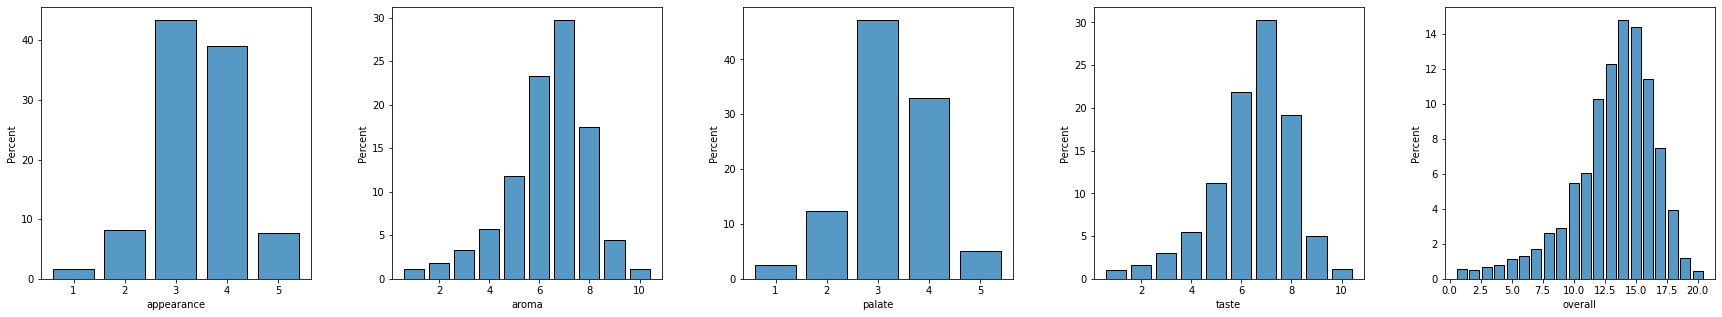

In [ ]:
fig, axs = plt.subplots(ncols=5)

fig.subplots_adjust(wspace=0.3)
fig.set_figheight(5)
fig.set_figwidth(30)

gen_histogram(0, rating_rb_model, axs[0])
gen_histogram(1, rating_rb_model, axs[1])
gen_histogram(2, rating_rb_model, axs[2])
gen_histogram(3, rating_rb_model, axs[3])
gen_histogram(4, rating_rb_model, axs[4])

##### Ocenpiwo

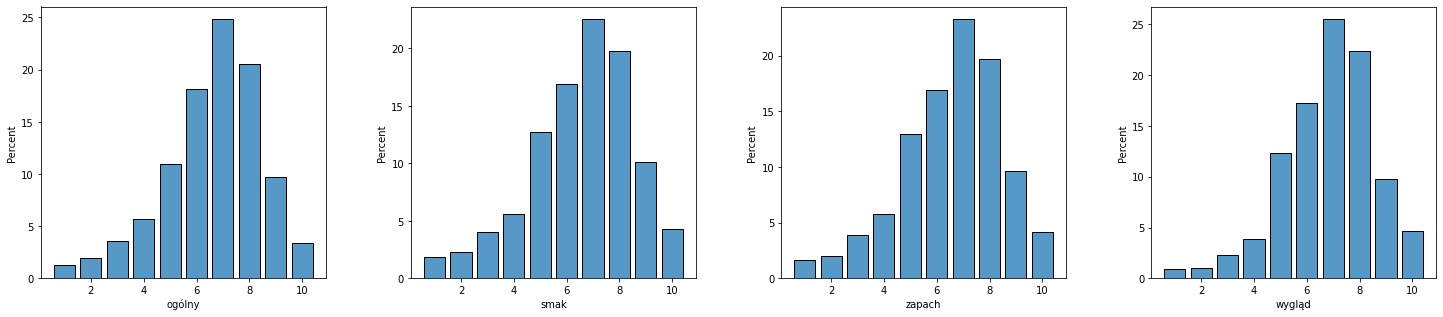

In [ ]:
fig, axs = plt.subplots(ncols=4)

fig.subplots_adjust(wspace=0.3)
fig.set_figheight(5)
fig.set_figwidth(25)

gen_histogram(0, rating_op_model, axs[0])
gen_histogram(1, rating_op_model, axs[1])
gen_histogram(2, rating_op_model, axs[2])
gen_histogram(3, rating_op_model, axs[3])

#### Heatmaps

We measure co-occurence of any non-overall and overall rating pair.


In [ ]:
import seaborn

def gen_heatmap(aspect1, aspect2, model, axis):
    s = seaborn.heatmap(model.alphas[(aspect1, aspect2)], 
                        xticklabels=range(1, model.ds.aspect_max[aspect1] + 1),
                        yticklabels=range(1, model.ds.aspect_max[aspect2] + 1),
                        cmap='bone',
                        ax=axis)
    s.set(xlabel=model.ds.aspects[aspect1], ylabel=model.ds.aspects[aspect2])

##### Ratebeer

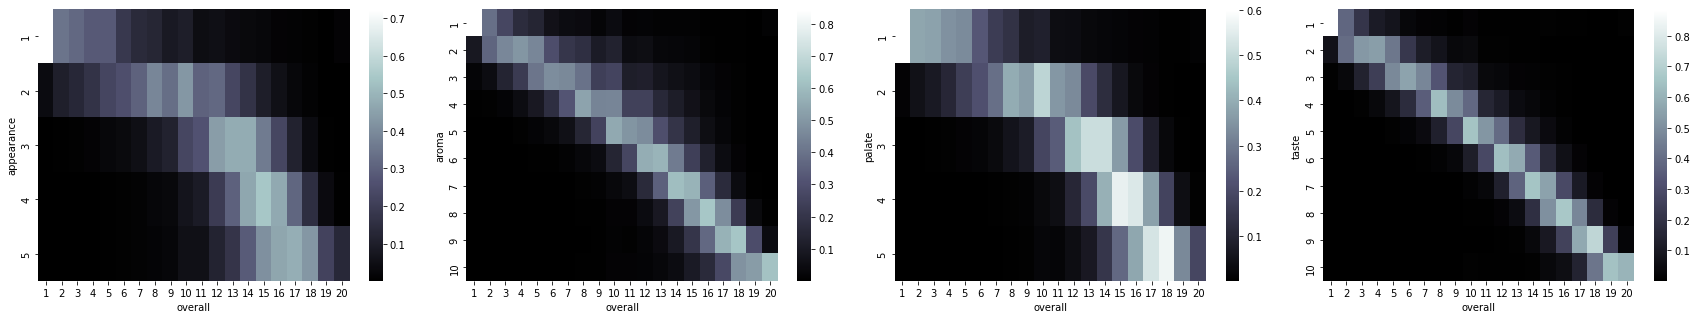

In [ ]:
fig, axs = plt.subplots(ncols=4)
fig.subplots_adjust(wspace=0.1)
fig.set_figheight(5)
fig.set_figwidth(30)

gen_heatmap(4, 0, rating_rb_model, axs[0])
gen_heatmap(4, 1, rating_rb_model, axs[1])
gen_heatmap(4, 2, rating_rb_model, axs[2])
gen_heatmap(4, 3, rating_rb_model, axs[3])

##### Ocen-piwo

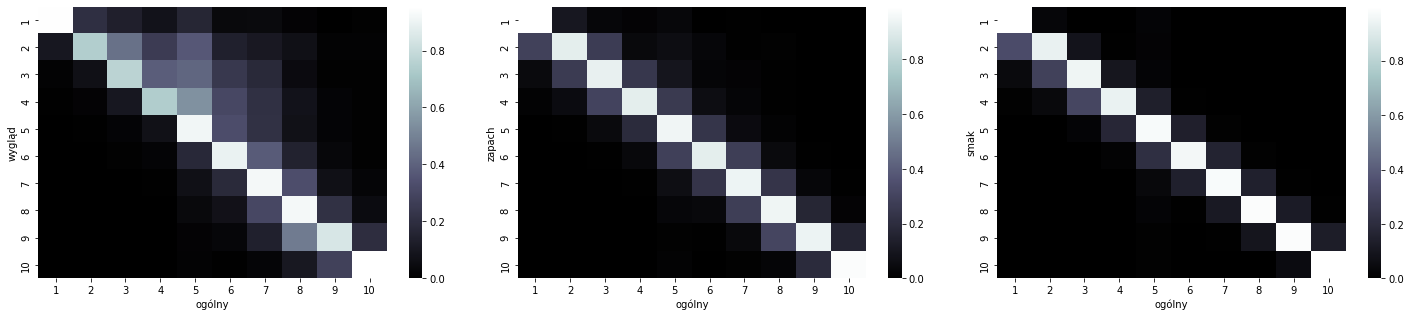

In [ ]:
fig, axs = plt.subplots(ncols=3)
fig.subplots_adjust(wspace=0.1)
fig.set_figheight(5)
fig.set_figwidth(25)

gen_heatmap(0, 3, rating_op_model, axs[0])
gen_heatmap(0, 2, rating_op_model, axs[1])
gen_heatmap(0, 1, rating_op_model, axs[2])

#### Confusion matrices

## Word embeddings

### Preliminary

##### Dependencies

In [ ]:
import torch
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'dev = {dev}')

In [ ]:
!pip install icecream torchtext sentence_transformers faiss-cpu faiss-gpu fasttext --quiet
!pip install spacy --upgrade --quiet
!python3 -m spacy download pl_core_news_md --quiet
!python3 -m spacy download en_core_web_sm

In [ ]:
import gc # garbage collector interface
import io
import re
import spacy # nlp toolkit
import torch
import pickle
from collections import Counter
from torchtext._torchtext import (Vocab as VocabPybind) # make use of some hidden interface
from torchtext.vocab import Vocab, build_vocab_from_iterator
from tqdm.notebook import trange, tqdm
from icecream import ic


class BaseReviews(torch.utils.data.Dataset):
    def __init__(self, aspects, aspect_max, aspect_ratings, texts, unkn_tok, _len, anchor_words):
        self.aspects = aspects
        self.aspect_count = len(aspects)
        self.aspect_max = aspect_max
        self._aspect_ratings = aspect_ratings
        self._texts = texts
        self.unkn_tok = unkn_tok
        self._len = _len
        self.anchor_words = anchor_words
        self.vocab = None

    def dump(self, dest_path, filename):
        contents = {
            'aspects'        : self.aspects,
            'aspect_max'     : self.aspect_max,
            '_aspect_ratings': self._aspect_ratings,
            '_texts'         : self._texts,
            'unkn_tok'       : self.unkn_tok,
            '_len'           : self._len,
            'anchor_words'   : self.anchor_words,
            'vocab'          : self.vocab,
        }
        with open(f'{dest_path}/{filename}', 'wb') as f:
            pickle.dump(contents, f)
    
    def load(self, dest_path, filename):
        with open(f'{dest_path}/{filename}', 'rb') as f:
            contents = pickle.load(f)
            self.aspects        = contents['aspects']
            self.aspect_max     = contents['aspect_max']
            self._aspect_ratings = contents['_aspect_ratings']
            self._texts          = contents['_texts']
            self.unkn_tok       = contents['unkn_tok']
            self._len           = contents['_len']
            self.anchor_words   = contents['anchor_words']
            self.vocab          = contents['vocab']

    def __getitem__(self, i):
        # # 1 # python
        # sentences = tuple(sent for sent in self._texts[i])
        # ratings = tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count))
        # 2 # tensor
        sentences = tuple(torch.LongTensor(sent) for sent in self._texts[i])
        ratings = torch.LongTensor(tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count)))
        # # 3 # dev
        # sentences = tuple(torch.tensor(sent) for sent in self._texts[i])
        # ratings = torch.tensor(tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count)))
        return (sentences, ratings)

    def __len__(self):
        return self._len

In [ ]:
try: # mount user's Google Drive if on Colab to save training artifacts
    from google.colab import drive
    drive.mount('/drive')
    ROOT_DIR = '/content/'
    MODEL_ROOT_DIR = '/drive/MyDrive/1e100ibu/saves'
except ImportError:
    ROOT_DIR = './'
    MODEL_ROOT_DIR = './saves/'

Mounted at /drive


### Ocen-piwo.pl representation

#### SBERT

Class that maps ocen-piwo.pl reviews to sentence embeddings using [Sentence-BERT](https://arxiv.org/abs/1908.10084) from [sentence-transformers](https://www.sbert.net/).

Model used: `distiluse-base-multilingual-cased-v1` ("multilingual knowledge distilled version of multilingual Universal Sentence Encoder. Supports 15 languages: Arabic, Chinese, Dutch, English, French, German, Italian, Korean, Polish, Portuguese, Russian, Spanish, Turkish").
This model is common for both the datasets.

The sentence embeddings are then averaged or maxpooled depending on constructor parameter.


In [ ]:
from collections import Counter
from torchtext._torchtext import (Vocab as VocabPybind) # make use of some hidden interface
from torchtext.vocab import Vocab, build_vocab_from_iterator
from tqdm.notebook import trange, tqdm
import gc # garbage collector interface
import io
import re
import spacy # nlp toolkit
import torch
import json
from tqdm.contrib.concurrent import thread_map
from typing import List
from sentence_transformers import SentenceTransformer, util

class OcenPiwoSBERTReviews(BaseReviews):
    def __init__(self, vec_agg='avg'):
        aspects = ['ogólny', 'smak', 'zapach', 'wygląd',]
        super().__init__(
            aspects        = aspects,
            aspect_max     = [10, 10, 10, 10],
            aspect_ratings = [ [] for _ in aspects ],
            texts          = [],
            unkn_tok       = '<unk>', # unknown/out of vocabulary token
            _len            = 0,
            anchor_words = {
                'ogólny'     : ('ogólnie'),
                'smak'       : ('smak'),
                'zapach'     : ('zapach'),
                'wygląd'     : ('wygląd', 'wygląda')
            },
        )
        self.pipe = None
        self.model = None
        self._vec_agg = vec_agg

    def dump(self, dest_path, filename): # override to use torch instead of pickle
        contents = {
            'aspects'        : self.aspects,
            'aspect_max'     : self.aspect_max,
            '_aspect_ratings': self._aspect_ratings,
            '_texts'         : self._texts,
            'unkn_tok'       : self.unkn_tok,
            '_len'           : self._len,
            'anchor_words'   : self.anchor_words,
            'vocab'          : self.vocab,
            'vec_agg'        : self._vec_agg
        }
        with open(f'{dest_path}/{filename}', 'wb') as f:
            torch.save(contents, f)
    
    def load(self, dest_path, filename): # override to use torch instead of pickle; additionaly save whether to apply avg or maxpool
        with open(f'{dest_path}/{filename}', 'rb') as f:
            contents = torch.load(f, map_location=torch.device(dev))
            self.aspects         = contents['aspects']
            self.aspect_max      = contents['aspect_max']
            self._aspect_ratings = contents['_aspect_ratings']
            self._texts          = contents['_texts']
            self.unkn_tok        = contents['unkn_tok']
            self._len            = contents['_len']
            self.anchor_words    = contents['anchor_words']
            self.vocab           = contents['vocab']
            self._vec_agg        = contents['vec_agg']

    def build(self, filepath=f'{ROOT_DIR}/ocen-piwo-utf8.json'):
        with io.open(filepath, encoding='utf-8') as f:
            json_dict = json.loads(f.read())

            for i, reviews in enumerate(json_dict.values()):
                for sentences, ratings in reviews:
                    self._len += 1
                    if self._len > 10: # TODO remove
                        break

                    for aspect in range(self.aspect_count):
                        self._aspect_ratings[aspect].append(int(ratings[aspect]))

                    self._texts.append(sentences)
        self._post_process()

    def _fetch_nlp_pipeline(self):
        if not self.pipe:
            nlp = spacy.load('pl_core_news_md')
            # we want sentencizer only, as tokenization is part of Transformer model we'll use
            for pipe_name in nlp.pipe_names:
                # if pipe_name != 'sentencizer':
                nlp.remove_pipe(pipe_name)
            nlp.add_pipe("sentencizer", config={"punct_chars": ['.', '?', '!']})
            self.pipe = nlp.pipe
    
    def _free_nlp_pipeline(self):
        self.pipe = None
    
    def _fetch_transformer_model(self):
        # self.model = model # TODO
        if not self.model:
            self.model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
    
    def _free_transformer_model(self):
        self.model = None

    def __getitem__(self, i):
        # # 1 # python
        # sentences = tuple(sent for sent in self._texts[i])
        # ratings = tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count))
        # 2 # tensor
        sentences = self._texts[i]
        ratings = torch.LongTensor(tuple(int(self._aspect_ratings[a][i]) for a in range(self.aspect_count)))
        # # 3 # dev
        # sentences = tuple(torch.tensor(sent) for sent in self._texts[i])
        # ratings = torch.tensor(tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count)))
        return (sentences, ratings)


    def text_embedding(self, text: str):
        self._fetch_transformer_model()
        self._fetch_nlp_pipeline()
        if 'avg' == self._vec_agg:
            return self.model.encode([sent.text for sent in next(self.pipe([text])).sents], convert_to_tensor=True).mean(dim=0)
        elif 'maxpool' == self._vec_agg:
            return self.model.encode([sent.text for sent in next(self.pipe([text])).sents], convert_to_tensor=True).max(dim=0)[0]
        else:
            assert False

    def sentences_avg_embedding(self, sentences: List[str]):
        return self.model.encode(sentences, convert_to_tensor=True).mean(dim=0)

    def sentences_maxpool_embedding(self, sentences: List[str]):
        return self.model.encode(sentences, convert_to_tensor=True).max(dim=0)[0]
    
    def closest_indices(self, text: str, top_k=20):
        text_emb = self.text_embedding(text)[None, :]
        result = util.semantic_search(query_embeddings=text_emb, corpus_embeddings=self._texts, top_k=top_k)
        return [(d['corpus_id'], d['score']) for d in result[0]]
    
    def knn_predict_rating(self, text: str, top_k=20):
        knn = self.closest_indices(text, top_k)
        indices, weights = [list(t) for t in zip(*knn)]
        weights = torch.tensor(weights)
        weights = weights / weights.sum()
        nearest_ratings = torch.stack(tuple(self[idx][1] for idx in indices)).to(torch.float)
        nearest_ratings *= weights[:, None]
        nearest_ratings = nearest_ratings.sum(dim=0)
        nearest_ratings.round_()
        return nearest_ratings
    
    def _post_process(self):
        print("Spacy pipe (sentence split)..")
        gc.collect() # force garbage collection
        self._fetch_nlp_pipeline()
        self._texts = [[sent.text for sent in doc.sents] for doc in self.pipe(self._texts)]
        for i, text in enumerate(self._texts):
            assert 0 != len(text) # make sure no empty reviews again (new could be introduced by removing stop words unfortunately)
        print("Mapping reviews to embeddings..")
        gc.collect() # force garbage collection
        self._fetch_transformer_model()
        if 'avg' == self._vec_agg:
            self._texts = torch.stack(thread_map(self.sentences_avg_embedding, self._texts, max_workers=1))
        elif 'maxpool' == self._vec_agg:
            self._texts = torch.stack(thread_map(self.sentences_maxpool_embedding, self._texts))
        else:
            assert False

In [ ]:
op = OcenPiwoSBERTReviews(vec_agg='avg')
# op.pipe = pipe # kinda cache by using old pipe and model when prototyping using notebook
# op.model = model # same as above
op.load(dest_path=MODEL_ROOT_DIR, filename='ocen-piwo-avg-sbert-vecs.pt')
# op.build(filepath='scrap-ocen-piwo/ocen-piwo-utf8.json')
# op.dump(dest_path=MODEL_ROOT_DIR, filename='ocen-piwo-avg-sbert-vecs.pt')
print(op.closest_indices('Jak dla mnie podstawka lepsza.')) # check: this input is 0-th review from the dataset, so hope for 0 be the most similar
print(op.knn_predict_rating('Najgorsze piwo jakie piłem kiedykolwiek'))

In [ ]:
op = OcenPiwoSBERTReviews(vec_agg='maxpool')
# op.pipe = pipe # kinda cache by using old pipe and model when prototyping using notebook
# op.model = model # same as above
# op.build('scrap-ocen-piwo/ocen-piwo-utf8.json')
# op.dump(dest_path=MODEL_ROOT_DIR, filename='ocen-piwo-maxpool-sbert-vecs.pt')
op.load(dest_path=MODEL_ROOT_DIR, filename='ocen-piwo-maxpool-sbert-vecs.pt')
print(op.closest_indices('Jak dla mnie podstawka lepsza.')) # check: this input is 0-th review from the dataset, so hope for 0 be the most similar
print(op.knn_predict_rating('Najgorsze piwo jakie piłem kiedykolwiek'))

#### FastText
Class that maps ocen-piwo.pl reviews to [FastText](https://fasttext.cc/) word embeddings using trained on Common Crawl: https://fasttext.cc/docs/en/crawl-vectors.html.

File: cc.pl.300.bin.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.pl.300.bin.gz

The word embeddings are then averaged or maxpooled depending on constructor parameter value.

We index vectors using [FAISS](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/).

In [ ]:
import gc # garbage collector interface
import io
import re
import spacy # nlp toolkit
import torch
import json
import fasttext
import fasttext.util
import numpy as np
import faiss
from typing import List
from tqdm.contrib.concurrent import thread_map
from icecream import ic
from collections import Counter
from torchtext._torchtext import (Vocab as VocabPybind) # make use of some hidden interface
from torchtext.vocab import Vocab, build_vocab_from_iterator
from tqdm.notebook import trange, tqdm

class OcenPiwoFasttextEmbeddedReviews(BaseReviews):
    def __init__(self, vec_agg='avg'):
        aspects = ['ogólny', 'smak', 'zapach', 'wygląd',]
        super().__init__(
            aspects        = aspects,
            aspect_max     = [10, 10, 10, 10],
            aspect_ratings = [ [] for _ in aspects ],
            texts          = [],
            unkn_tok       = '<unk>', # unknown/out of vocabulary token
            _len            = 0,
            anchor_words = {
                'ogólny'     : ('ogólnie'),
                'smak'       : ('smak'),
                'zapach'     : ('zapach'),
                'wygląd'     : ('wygląd', 'wygląda')
            },
        )
        self.pipe = None
        self.model = None
        self._vec_agg = vec_agg
        self._index = None

    def dump(self, dest_path, filename): # override to use torch instead of pickle
        contents = {
            'aspects'        : self.aspects,
            'aspect_max'     : self.aspect_max,
            '_aspect_ratings': self._aspect_ratings,
            '_texts'         : self._texts,
            'unkn_tok'       : self.unkn_tok,
            '_len'           : self._len,
            'anchor_words'   : self.anchor_words,
            'vocab'          : self.vocab,
            'vec_agg'        : self._vec_agg
        }
        with open(f'{dest_path}/{filename}', 'wb') as f:
            torch.save(contents, f)
    
    def load(self, dest_path, filename): # override to use torch instead of pickle; additionaly save whether to apply avg or maxpool
        with open(f'{dest_path}/{filename}', 'rb') as f:
            contents = torch.load(f, map_location=torch.device(dev))
            self.aspects         = contents['aspects']
            self.aspect_max      = contents['aspect_max']
            self._aspect_ratings = contents['_aspect_ratings']
            self._texts          = contents['_texts']
            self.unkn_tok        = contents['unkn_tok']
            self._len            = contents['_len']
            self.anchor_words    = contents['anchor_words']
            self.vocab           = contents['vocab']
            self._vec_agg        = contents['vec_agg']

    def build(self, filepath=f'{ROOT_DIR}/ocen-piwo-utf8.json'):
        with io.open(filepath, encoding='utf-8') as f:
            json_dict = json.loads(f.read())

            for i, reviews in enumerate(json_dict.values()):
                for sentences, ratings in reviews:
                    self._len += 1
                    if self._len > 1000: # TODO remove
                        break

                    for aspect in range(self.aspect_count):
                        self._aspect_ratings[aspect].append(int(ratings[aspect]))

                    self._texts.append(sentences)
        self._post_process()

    def _fetch_nlp_pipeline(self):
        if not self.pipe:
            nlp = spacy.load('pl_core_news_md')
            # we want sentencizer only, as tokenization is part of Transformer model we'll use
            # ic(nlp.pipe_names) # 'tok2vec', 'morphologizer', 'parser', 'tagger', 'attribute_ruler', 'lemmatizer', 'ner'
            for pipe_name in nlp.pipe_names:
                if pipe_name not in ['tokenizer', 'lemmatizer']:
                    nlp.remove_pipe(pipe_name)
            nlp.add_pipe("sentencizer", config={"punct_chars": ['.', '?', '!']})
            self.pipe = lambda texts: [[tok.lemma_ for sent in doc.sents for tok in sent if not tok.is_punct and not tok.is_space] for doc in nlp.pipe(texts)] # TODO remove stop words? (not tok.is_stop)
    
    def _free_nlp_pipeline(self):
        self.pipe = None
    
    def _fetch_model(self):
        if not self.model:
            self.model = fasttext.load_model(f'{MODEL_ROOT_DIR}/../vectors/cc.pl.300.bin')
    
    def _free_model(self):
        self.model = None

    def __getitem__(self, i):
        # # 1 # python
        # sentences = tuple(sent for sent in self._texts[i])
        # ratings = tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count))
        # 2 # tensor
        sentences = self._texts[i]
        ratings = torch.LongTensor(tuple(int(self._aspect_ratings[a][i]) for a in range(self.aspect_count)))
        # # 3 # dev
        # sentences = tuple(torch.tensor(sent) for sent in self._texts[i])
        # ratings = torch.tensor(tuple(self._aspect_ratings[a][i] for a in range(self.aspect_count)))
        return (sentences, ratings)


    def text_embedding(self, text: str):
        """tokenize text, and return mean/maxpool of the token vectors """
        self._fetch_nlp_pipeline()
        self._fetch_model()
        words = self.pipe([text])[0] # self.pipe is for list of texts and returns a list; we grab oth list of the result because of this
        vecs = np.vstack([self.model[word] for word in words])
        if 'avg' == self._vec_agg:
            return vecs.mean(axis=0)
        elif 'maxpool' == self._vec_agg:
            return vecs.max(axis=0)
        else:
            assert False

    def words_avg_embedding(self, words: List[str]):
        """ treat words as bag of words, return average of their vectors """
        vecs = np.vstack([self.model[word] for word in words])
        return vecs.mean(axis=0)

    def words_maxpool_embedding(self, words: List[str]):
        """ treat words as bag of words, return max of their vectors (position-wise) """
        vecs = np.vstack([self.model[word] for word in words])
        return vecs.max(axis=0)
    
    def closest_indices(self, text: str, top_k=20):
        self._set_up_texts_index()
        text_emb = self.text_embedding(text)[None, :] # introduce new dimension for vector count (here only 1 vector)
        result = self._index.search(text_emb, top_k)
        # result[0] is list of similiarities list, result[1] is list of list
        # we get [0] which means result for 0th vector passed to search (the single one we passed)
        result = (result[0][0], result[1][0])
        return result
    
    def knn_predict_rating(self, text: str, top_k=10):
        knn = self.closest_indices(text, top_k)
        weights, indices = knn
        weights = np.array(weights)
        weights = weights / weights.sum()
        nearest_ratings = np.vstack(tuple(self[idx][1] for idx in indices)).astype(np.float32)
        nearest_ratings *= weights[:, None]
        nearest_ratings = nearest_ratings.sum(axis=0)
        nearest_ratings = np.rint(nearest_ratings)
        return nearest_ratings
    
    def _set_up_texts_index(self):
        """set up index for vector-encoded corpora texts"""
        if self._index is None:
            if hasattr(faiss, 'StandardGpuResources'):
                # gpu mode
                res = faiss.StandardGpuResources()
                config = faiss.GpuIndexFlatConfig()
                config.device = 0
                self._index = faiss.GpuIndexFlatIP(res, self._texts.shape[1], config)
            else:
                # cpu mode
                self._index = faiss.IndexFlatIP(self._texts.shape[1])
            if True:
                faiss.normalize_L2(self._texts)
            self._index.add(self._texts)

    def _post_process(self):
        print("Spacy pipe (sentence split&tokenization)..")
        gc.collect() # force garbage collection
        self._fetch_nlp_pipeline()
        self._texts = self.pipe(self._texts)
        i = 0
        while True:
            if len(self._texts) <= i:
                break
            if 0 == len(self._texts[i]): # review with no tokens -> remove
                del self._texts[i]
                for a_idx, _ in enumerate(self.aspects):
                    del self._aspect_ratings[a_idx][i]
            else:
                i += 1
        for i, text in enumerate(self._texts):
            assert 0 != len(text) # make sure no empty reviews again (new could be introduced by removing stop words unfortunately)
        print("Mapping reviews to embeddings..")
        # gc.collect() # force garbage collection
        self._fetch_model()
        if 'avg' == self._vec_agg:
            self._texts = np.vstack(thread_map(self.words_avg_embedding, self._texts, max_workers=1))
        elif 'maxpool' == self._vec_agg:
            self._texts = np.vstack(thread_map(self.words_maxpool_embedding, self._texts))
        else:
            assert False
        self._set_up_texts_index()

In [ ]:
op = OcenPiwoFasttextEmbeddedReviews(vec_agg='avg')
# op.pipe = pipe # kinda cache by using old pipe and model when prototyping using notebook
# op.model = model # same as above
# op.load(dest_path=ROOT_DIR, filename='ocen-piwo-avg-fasttext-vecs.pt')
# op.build(filepath=f'{MODEL_ROOT_DIR}/../ocen-piwo-utf8.json')
op.load(dest_path=MODEL_ROOT_DIR, filename='ocen-piwo-avg-fasttext-vecs.pt')
print(op.closest_indices('Jak dla mnie podstawka lepsza.')) # check: this input is 0-th review from the dataset, so hope for 0 be the most similar
print(op.knn_predict_rating('Najgorsze piwo jakie piłem kiedykolwiek'))

In [ ]:
pipe = op.pipe # kinda cache by using old pipe and model when prototyping using notebook
model = op.model # same as above

In [ ]:
# pipe = op.pipe
op = OcenPiwoFasttextEmbeddedReviews(vec_agg='maxpool')
op.pipe = pipe # kinda cache by using old pipe and model when prototyping using notebook
op.model = model # same as above
# op.load(dest_path=ROOT_DIR, filename='ocen-piwo-maxpool-fasttext-vecs.pt')
# op.build(filepath=f'{MODEL_ROOT_DIR}/../ocen-piwo-utf8.json')
op.load(dest_path=MODEL_ROOT_DIR, filename='ocen-piwo-maxpool-fasttext-vecs.pt')
print(op.closest_indices('Jak dla mnie podstawka lepsza.')) # check: this input is 0-th review from the dataset, so hope for 0 be the most similar
print(op.knn_predict_rating('Najgorsze piwo jakie piłem kiedykolwiek'))

### SNAP RateBeer representation

#### SBERT

Class that maps ocen-piwo.pl reviews to sentence embeddings using [Sentence-BERT](https://arxiv.org/abs/1908.10084) from [sentence-transformers](https://www.sbert.net/).

Model used: `distiluse-base-multilingual-cased-v1` ("multilingual knowledge distilled version of multilingual Universal Sentence Encoder. Supports 15 languages: Arabic, Chinese, Dutch, English, French, German, Italian, Korean, Polish, Portuguese, Russian, Spanish, Turkish").
This model is common for both the datasets.

The sentence embeddings are then averaged or maxpooled depending on constructor parameter.


In [ ]:
class RateBeerSBERTReviews(OcenPiwoSBERTReviews):
    """
    beer/name: John Harvards Simcoe IPA
    beer/beerId: 63836
    beer/brewerId: 8481
    beer/ABV: 5.4
    beer/style: India Pale Ale &#40;IPA&#41;
    review/appearance: 4/5
    review/aroma: 6/10
    review/palate: 3/5
    review/taste: 6/10
    review/overall: 13/20
    review/time: 1157587200
    review/profileName: hopdog
    review/text: On tap at the Springfield, PA location. Poured a deep and cloudy orange (almost a copper) color with a small sized off white head. Aromas or oranges and all around citric. Tastes of oranges, light caramel and a very light grapefruit finish. I too would not believe the 80+ IBUs - I found this one to have a very light bitterness with a medium sweetness to it. Light lacing left on the glass.
    """
    def __init__(self, vec_agg='avg'):
        aspects = ['appearance', 'aroma', 'palate', 'taste', 'overall']
        BaseReviews.__init__(
            self,
            aspects        = aspects,
            aspect_max     = [5, 10, 5, 10, 20],
            aspect_ratings = [ [] for _ in aspects ],
            texts          = [],
            unkn_tok       = '<unk>', # unknown/out of vocabulary token
            _len            = 0,
            anchor_words = {
                'appearance' : ('appearance', 'color'),
                'aroma'      : ('aroma'),
                'palate'     : ('palate', 'mouthfeel'),
                'taste'      : ('taste'),
                'overall'    : ('overall'),
            },
        )
        self.pipe = None
        self.model = None
        self._vec_agg = vec_agg

    def build(self, filepath=f'{ROOT_DIR}/SNAP-Ratebeer.txt', max_reviews=float('inf')):
        with io.open(filepath, encoding='utf-8') as f:
            for line in tqdm(f, total=(40938282 if max_reviews == float('inf') else max_reviews * 14), desc='Reading data'):
                if line == '\n': # separator
                    self._len += 1
                    if max_reviews <= self._len:
                        break
                elif line.startswith('review/appearance: '):
                    line = line[len('review/appearance: '):]
                    self._aspect_ratings[0].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/aroma: '):
                    line = line[len('review/aroma: '):]
                    self._aspect_ratings[1].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/palate: '):
                    line = line[len('review/palate: '):]
                    self._aspect_ratings[2].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/taste: '):
                    line = line[len('review/taste: '):]
                    self._aspect_ratings[3].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/overall: '):
                    line = line[len('review/overall: '):]
                    self._aspect_ratings[4].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/text: '):
                    line = line[len('review/text: '):]
                    if line.startswith('UPDATED:'):
                        line = line[len("UPDATED: APR 29, 2008"):] # drop prefix
                    line = re.sub('~', ' ', line.strip()) # remove whitespace incl. trailing newline and tildes that can be found in data for some reason
                    if line:
                        self._texts.append(line)
                    else: # some reviews do not have associated text; unwind (remove) their ratings for each aspect
                        for aspect_ratings in self._aspect_ratings:
                            aspect_ratings.pop()
                        self._len -= 1
        gc.collect()
        self._post_process()
    
    def _fetch_nlp_pipeline(self):
        if not self.pipe:
            nlp = spacy.util.get_lang_class('en')()
            # we want sentencizer only, as tokenization is part of Transformer model we'll use
            for pipe_name in nlp.pipe_names:
                # if pipe_name != 'sentencizer':
                nlp.remove_pipe(pipe_name)
            nlp.add_pipe("sentencizer", config={"punct_chars": ['.', '?', '!']})
            self.pipe = nlp.pipe
    
    def _free_nlp_pipeline(self):
        self.nlp = None

In [ ]:
rb = RateBeerSBERTReviews(vec_agg='avg')
# rb.pipe = pipe # kinda cache by using old pipe and model when prototyping using notebook
# rb.model = model # same as above
# rb.load(dest_path=MODEL_ROOT_DIR, filename='ratebeer-avg-sbert-vecs.pt')
# rb.build(filepath='/drive/MyDrive/Colab Notebooks/1e100ibu/SNAP-Ratebeer.txt', max_reviews=1e6)
rb.load(dest_path=MODEL_ROOT_DIR, filename='ratebeer-avg-sbert-vecs.pt')
rb.closest_indices('Worst beer i have ever seen') # check: this input is 0-th review from the dataset, so hope for 0 be the most similar
print(rb.knn_predict_rating('Tastes best from bottle. Not so heap as one could think. Nice hoppy smell. I had not supposed it will be sour though. Beautiful smooth head.'))

In [ ]:
pipe = rb.pipe # kinda cache by using old pipe and model when prototyping using notebook
model = rb.model # same as above

In [ ]:
rb = RateBeerSBERTReviews(vec_agg='maxpool')
# rb.pipe = pipe # kinda cache by using old pipe and model when prototyping using notebook
# rb.model = model # same as above
# rb.load(dest_path=MODEL_ROOT_DIR, filename='ratebeer-maxpool-sbert-vecs.pt')
# rb.build(filepath='/drive/MyDrive/Colab Notebooks/1e100ibu/SNAP-Ratebeer.txt', max_reviews=1e6)
rb.load(dest_path=MODEL_ROOT_DIR, filename='ratebeer-maxpool-sbert-vecs.pt')
print(rb.closest_indices('Worst beer i have ever seen')) # check: this input is 0-th review from the dataset, so hope for 0 be the most similar
print(rb.knn_predict_rating('Tastes best from bottle. Not so heap as one could think. Nice hoppy smell. I had not supposed it will be sour though. Beautiful smooth head.'))

### FastText
Class that maps SNAP Ratebeer reviews to [FastText](https://fasttext.cc/) word embeddings using trained on Common Crawl: https://fasttext.cc/docs/en/crawl-vectors.html.

File: cc.en.300.bin.gz https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz

The word embeddings are then averaged or maxpooled depending on constructor parameter value.

We index vectors using [FAISS](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/).

In [ ]:
class RateBeerFasttextReviews(OcenPiwoFasttextEmbeddedReviews):
    """
    beer/name: John Harvards Simcoe IPA
    beer/beerId: 63836
    beer/brewerId: 8481
    beer/ABV: 5.4
    beer/style: India Pale Ale &#40;IPA&#41;
    review/appearance: 4/5
    review/aroma: 6/10
    review/palate: 3/5
    review/taste: 6/10
    review/overall: 13/20
    review/time: 1157587200
    review/profileName: hopdog
    review/text: On tap at the Springfield, PA location. Poured a deep and cloudy orange (almost a copper) color with a small sized off white head. Aromas or oranges and all around citric. Tastes of oranges, light caramel and a very light grapefruit finish. I too would not believe the 80+ IBUs - I found this one to have a very light bitterness with a medium sweetness to it. Light lacing left on the glass.
    """
    def __init__(self, vec_agg='avg'):
        aspects = ['appearance', 'aroma', 'palate', 'taste', 'overall']
        BaseReviews.__init__(
            self,
            aspects        = aspects,
            aspect_max     = [5, 10, 5, 10, 20],
            aspect_ratings = [ [] for _ in aspects ],
            texts          = [],
            unkn_tok       = '<unk>', # unknown/out of vocabulary token
            _len            = 0,
            anchor_words = {
                'appearance' : ('appearance', 'color'),
                'aroma'      : ('aroma'),
                'palate'     : ('palate', 'mouthfeel'),
                'taste'      : ('taste'),
                'overall'    : ('overall'),
            },
        )
        self.pipe = None
        self.model = None
        self._vec_agg = vec_agg
        self._index = None

    def build(self, filepath=f'{ROOT_DIR}/SNAP-Ratebeer.txt', max_reviews=float('inf')):
        with io.open(filepath, encoding='utf-8') as f:
            for line in tqdm(f, total=(40938282 if max_reviews == float('inf') else max_reviews * 14), desc='Reading data'):
                if line == '\n': # separator
                    self._len += 1
                    if max_reviews <= self._len:
                        break
                elif line.startswith('review/appearance: '):
                    line = line[len('review/appearance: '):]
                    self._aspect_ratings[0].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/aroma: '):
                    line = line[len('review/aroma: '):]
                    self._aspect_ratings[1].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/palate: '):
                    line = line[len('review/palate: '):]
                    self._aspect_ratings[2].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/taste: '):
                    line = line[len('review/taste: '):]
                    self._aspect_ratings[3].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/overall: '):
                    line = line[len('review/overall: '):]
                    self._aspect_ratings[4].append(int(line.split('/')[0])) # lhs of split by '/' is rating, rhs is max possible rating
                elif line.startswith('review/text: '):
                    line = line[len('review/text: '):]
                    if line.startswith('UPDATED:'):
                        line = line[len("UPDATED: APR 29, 2008"):] # drop prefix
                    line = re.sub('~', ' ', line.strip()) # remove whitespace incl. trailing newline and tildes that can be found in data for some reason
                    if line:
                        self._texts.append(line)
                    else: # some reviews do not have associated text; unwind (remove) their ratings for each aspect
                        for aspect_ratings in self._aspect_ratings:
                            aspect_ratings.pop()
                        self._len -= 1
        gc.collect()
        self._post_process()
    
    def _fetch_nlp_pipeline(self):
        if not self.pipe:
            nlp = spacy.load('en_core_web_sm')
            for pipe_name in nlp.pipe_names:
                if pipe_name not in ['tokenizer']:
                    nlp.remove_pipe(pipe_name)
            nlp.add_pipe("sentencizer", config={"punct_chars": ['.', '?', '!']})
            self.pipe = lambda texts: [[tok.lower_ for sent in doc.sents for tok in sent if not tok.is_punct and not tok.is_space] for doc in nlp.pipe(texts)] # TODO remove stop words? (not tok.is_stop); do not lowercase?
    
    def _fetch_model(self):
        if not self.model:
            self.model = fasttext.load_model(f'{MODEL_ROOT_DIR}/../vectors/cc.en.300.bin')

In [ ]:
rb = RateBeerFasttextReviews(vec_agg='avg')
# rb.pipe = pipe # kinda cache by using old pipe and model when prototyping using notebook
# rb.model = model # same as above
# rb.load(dest_path=MODEL_ROOT_DIR, filename='ratebeer-avg-fasttext-vecs.pt')
# rb.build(filepath='/drive/MyDrive/Colab Notebooks/1e100ibu/SNAP-Ratebeer.txt', max_reviews=1e6)
rb.load(dest_path=MODEL_ROOT_DIR, filename='ratebeer-avg-fasttext-vecs.pt')
print(rb.closest_indices('Worst beer i have ever seen')) # check: this input is 0-th review from the dataset, so hope for 0 be the most similar
print(rb.knn_predict_rating('Tastes best from bottle. Not so heap as one could think. Nice hoppy smell. I had not supposed it will be sour though. Beautiful smooth head.'))

In [ ]:
pipe = rb.pipe # reuse old pipe and model when prototyping using notebook
model = rb.model # same as above

In [ ]:
rb = RateBeerFasttextReviews(vec_agg='maxpool')
# rb.pipe = pipe # kinda cache by using old pipe and model when prototyping using notebook
# rb.model = model # same as above
# rb.load(dest_path=MODEL_ROOT_DIR, filename='ratebeer-maxpool-fasttext-vecs.pt')
# rb.build(filepath='/drive/MyDrive/Colab Notebooks/1e100ibu/SNAP-Ratebeer.txt', max_reviews=1e6)
rb.load(dest_path=MODEL_ROOT_DIR, filename='ratebeer-maxpool-fasttext-vecs.pt')
print(rb.closest_indices('Worst beer i have ever seen')) # check: this input is 0-th review from the dataset, so hope for 0 be the most similar
print(rb.knn_predict_rating('Tastes best from bottle. Not so heap as one could think. Nice hoppy smell. I had not supposed it will be sour though. Beautiful smooth head.'))

### Rating prediction

All classes in the last section implement KNN search and thus enable as to predict review ratings by calculating weighted average of its nearest neighbours ratings.

Below we cross-validate rating prediction accuracy in many settings. Our budget allowed us only for first 1K reviews of both datasets.

#### Cross-validation results for FastText

In [ ]:
def benchmark_fasttext(model, k, n_iter):
    predicted = []
    ground_truth = list(zip(*model._aspect_ratings))[:n_iter]
    correct_guesses = 0

    # very importando
    model._set_up_texts_index()

    for i in tqdm(range(n_iter), leave=None):
        review, rating = model[i]
        result = model._index.search(review[None, :], k)
        scores, indices = result[0][0], result[1][0]
        
        item_index = np.where(indices != i)
        
        scores = scores[item_index]
        indices = indices[item_index]

        scores = np.array(scores)
        nearest_ratings = np.vstack(tuple(model[idx][1] for idx in indices)).astype(np.float32)
        nearest_ratings = np.rint(np.average(nearest_ratings, weights=scores, axis=0))

        correct_guesses += (nearest_ratings == rating.numpy()).sum()

        predicted.append(nearest_ratings)

    predicted = np.vstack(predicted)
    ground_truth = np.vstack(ground_truth)
    mse = np.square(predicted - ground_truth).mean()

    print("Correct guesses: ", correct_guesses, ", out of: ", model.aspect_count * n_iter, ", percentage: ", correct_guesses / (model.aspect_count * n_iter))
    print("MSE: ", mse)

In [ ]:
for k in tqdm([2, 3, 5, 10, 15, 30]):
    print('------------------------------')
    print("K: ", k)

    model = OcenPiwoFasttextEmbeddedReviews(vec_agg='maxpool')
    model.load(dest_path=MODEL_ROOT_DIR, filename='ocen-piwo-maxpool-fasttext-vecs.pt')
    print("Testing maxpool - ocenpiwo")
    benchmark_fasttext(model, k, 1000)
    print()

    model = OcenPiwoFasttextEmbeddedReviews(vec_agg='avg')
    model.load(dest_path=MODEL_ROOT_DIR, filename='ocen-piwo-avg-fasttext-vecs.pt')
    print("Testing avg - ocenpiwo")
    benchmark_fasttext(model, k, 1000)
    print()

    model = RateBeerFasttextReviews(vec_agg='avg')
    model.load(dest_path=MODEL_ROOT_DIR, filename='ratebeer-avg-fasttext-vecs.pt')
    print("Testing maxpool - ratebeer")
    benchmark_fasttext(model, k, 1000)
    print()

    model = RateBeerFasttextReviews(vec_agg='maxpool')
    model.load(dest_path=MODEL_ROOT_DIR, filename='ratebeer-maxpool-fasttext-vecs.pt')
    print("Testing avg - ratebeer")
    benchmark_fasttext(model, k, 1000)

  0%|          | 0/6 [00:00<?, ?it/s]

------------------------------
K:  2
Testing maxpool - ocenpiwo


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  808 , out of:  4000 , percentage:  0.202
MSE:  5.1845

Testing avg - ocenpiwo


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1041 , out of:  4000 , percentage:  0.26025
MSE:  4.052

Testing maxpool - ratebeer


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1721 , out of:  5000 , percentage:  0.3442
MSE:  3.0624

Testing avg - ratebeer


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1556 , out of:  5000 , percentage:  0.3112
MSE:  3.9036
------------------------------
K:  3
Testing maxpool - ocenpiwo


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  911 , out of:  4000 , percentage:  0.22775
MSE:  3.788

Testing avg - ocenpiwo


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1127 , out of:  4000 , percentage:  0.28175
MSE:  3.0355

Testing maxpool - ratebeer


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1859 , out of:  5000 , percentage:  0.3718
MSE:  2.3784

Testing avg - ratebeer


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1664 , out of:  5000 , percentage:  0.3328
MSE:  2.8254
------------------------------
K:  5
Testing maxpool - ocenpiwo


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1015 , out of:  4000 , percentage:  0.25375
MSE:  3.07775

Testing avg - ocenpiwo


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1192 , out of:  4000 , percentage:  0.298
MSE:  2.51175

Testing maxpool - ratebeer


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1996 , out of:  5000 , percentage:  0.3992
MSE:  1.9784

Testing avg - ratebeer


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1843 , out of:  5000 , percentage:  0.3686
MSE:  2.222
------------------------------
K:  10
Testing maxpool - ocenpiwo


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1019 , out of:  4000 , percentage:  0.25475
MSE:  2.82375

Testing avg - ocenpiwo


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1214 , out of:  4000 , percentage:  0.3035
MSE:  2.32475

Testing maxpool - ratebeer


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  2097 , out of:  5000 , percentage:  0.4194
MSE:  1.7782

Testing avg - ratebeer


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1981 , out of:  5000 , percentage:  0.3962
MSE:  1.9586
------------------------------
K:  15
Testing maxpool - ocenpiwo


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  996 , out of:  4000 , percentage:  0.249
MSE:  2.73325

Testing avg - ocenpiwo


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1144 , out of:  4000 , percentage:  0.286
MSE:  2.31275

Testing maxpool - ratebeer


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  2137 , out of:  5000 , percentage:  0.4274
MSE:  1.7366

Testing avg - ratebeer


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  2061 , out of:  5000 , percentage:  0.4122
MSE:  1.8494
------------------------------
K:  30
Testing maxpool - ocenpiwo


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  989 , out of:  4000 , percentage:  0.24725
MSE:  2.70025

Testing avg - ocenpiwo


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1178 , out of:  4000 , percentage:  0.2945
MSE:  2.27925

Testing maxpool - ratebeer


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  2175 , out of:  5000 , percentage:  0.435
MSE:  1.6756

Testing avg - ratebeer


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  2079 , out of:  5000 , percentage:  0.4158
MSE:  1.819


We do not see a clear winner when comparing max pooling with average pooling here. Surprisingly, we see improvement as a result of increasing the parameter k up to the value of 30.

### Cross-validation results for SBERT

In [ ]:
def benchmark_sbert(model, k, n_iter):
    predicted = []
    ground_truth = list(zip(*model._aspect_ratings))[:n_iter]
    correct_guesses = 0

    for i in tqdm(range(n_iter), leave=None):
        review, rating = model[i]

        result = util.semantic_search(query_embeddings=review[None, :], corpus_embeddings=model._texts, top_k=k)
        
        result = list(filter(lambda res: res['corpus_id'] != i, result[0]))

        scores = [res['score'] for res in result]
        indices = [res['corpus_id'] for res in result]

        scores = np.array(scores)
        nearest_ratings = np.vstack(tuple(model[idx][1] for idx in indices)).astype(np.float32)
        nearest_ratings = np.rint(np.average(nearest_ratings, weights=scores, axis=0))

        correct_guesses += (nearest_ratings == rating.numpy()).sum()

        predicted.append(nearest_ratings)

    predicted = np.vstack(predicted)
    ground_truth = np.vstack(ground_truth)
    mse = np.square(predicted - ground_truth).mean()

    print("Correct guesses: ", correct_guesses, ", out of: ", model.aspect_count * n_iter, ", percentage: ", correct_guesses / (model.aspect_count * n_iter))
    print("MSE: ", mse)

In [ ]:
print("Testing avg - ocenpiwo")
print('------------------------------')
model = OcenPiwoSBERTReviews(vec_agg='avg')
model.load(dest_path=MODEL_ROOT_DIR, filename='ocen-piwo-avg-sbert-vecs.pt')
for k in tqdm([2, 3, 5, 10, 15, 30], leave=None):
    print("K: ", k)
    benchmark_sbert(model, k, 1000)
    print()

print("Testing maxpool - ocenpiwo")
print('------------------------------')
model = OcenPiwoSBERTReviews(vec_agg='maxpool')
model.load(dest_path=MODEL_ROOT_DIR, filename='ocen-piwo-maxpool-fasttext-vecs.pt')
for k in tqdm([2, 3, 5, 10, 15, 30], leave=None):
    print("K: ", k)
    benchmark_sbert(model, k, 1000)
    print()

print("Testing maxpool - ratebeer")
print('------------------------------')
model = RateBeerSBERTReviews(vec_agg='maxpool')
model.load(dest_path=MODEL_ROOT_DIR, filename='ratebeer-maxpool-sbert-vecs.pt')
for k in tqdm([2, 3, 5, 10, 15, 30], leave=None):
    print("K: ", k)
    benchmark_sbert(model, k, 1000)
    print()

print("Testing avg - ratebeer")
print('------------------------------')
model = RateBeerSBERTReviews(vec_agg='avg')
model.load(dest_path=MODEL_ROOT_DIR, filename='ratebeer-avg-sbert-vecs.pt')
for k in tqdm([2, 3, 5, 10, 15, 30], leave=None):
    print("K: ", k)
    benchmark_sbert(model, k, 1000)
    print()

Testing avg - ocenpiwo
------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

K:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1180 , out of:  4000 , percentage:  0.295
MSE:  3.30075

K:  3


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1315 , out of:  4000 , percentage:  0.32875
MSE:  2.57275

K:  5


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1364 , out of:  4000 , percentage:  0.341
MSE:  2.15225

K:  10


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1411 , out of:  4000 , percentage:  0.35275
MSE:  1.9345

K:  15


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1422 , out of:  4000 , percentage:  0.3555
MSE:  1.89125

K:  30


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1386 , out of:  4000 , percentage:  0.3465
MSE:  1.93125

Testing maxpool - ocenpiwo
------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

K:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  808 , out of:  4000 , percentage:  0.202
MSE:  5.1845

K:  3


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  911 , out of:  4000 , percentage:  0.22775
MSE:  3.788

K:  5


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1015 , out of:  4000 , percentage:  0.25375
MSE:  3.07775

K:  10


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1018 , out of:  4000 , percentage:  0.2545
MSE:  2.824

K:  15


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  996 , out of:  4000 , percentage:  0.249
MSE:  2.73325

K:  30


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  989 , out of:  4000 , percentage:  0.24725
MSE:  2.70025

Testing maxpool - ratebeer
------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

K:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1768 , out of:  5000 , percentage:  0.3536
MSE:  3.0958

K:  3


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1906 , out of:  5000 , percentage:  0.3812
MSE:  2.4534

K:  5


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  2033 , out of:  5000 , percentage:  0.4066
MSE:  2.1464

K:  10


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  2069 , out of:  5000 , percentage:  0.4138
MSE:  1.9706

K:  15


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  2068 , out of:  5000 , percentage:  0.4136
MSE:  1.9456

K:  30


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  2084 , out of:  5000 , percentage:  0.4168
MSE:  1.8986

Testing avg - ratebeer
------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

K:  2


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1826 , out of:  5000 , percentage:  0.3652
MSE:  2.4442

K:  3


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  1938 , out of:  5000 , percentage:  0.3876
MSE:  1.9432

K:  5


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  2086 , out of:  5000 , percentage:  0.4172
MSE:  1.6464

K:  10


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  2233 , out of:  5000 , percentage:  0.4466
MSE:  1.4906

K:  15


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  2257 , out of:  5000 , percentage:  0.4514
MSE:  1.4624

K:  30


  0%|          | 0/1000 [00:00<?, ?it/s]

Correct guesses:  2289 , out of:  5000 , percentage:  0.4578
MSE:  1.4378



As we can see, this time average pooling surely wins compared with max pooling. Increasing k results in better predictions as well.

In [ ]:
print("Testing avg - ocenpiwo")
print('------------------------------')
model = OcenPiwoSBERTReviews(vec_agg='avg')
model.load(dest_path=MODEL_ROOT_DIR, filename='ocen-piwo-avg-sbert-vecs.pt')
for k in tqdm([2, 3, 5, 10, 15, 30], leave=None):
    print("K: ", k)
    benchmark_sbert(model, k, 1000)
    print()

